# Análise do PIB de países com Graph Neural Networks (GNN) Classification

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px


### Carregando o dataset com os países vizinhos

In [2]:
json_file_path = "nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())

### Carregando o dataset com os dados dos países

In [3]:
path = "countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')
df_gdp.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,American Samoa,Andorra
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,OCEANIA,WESTERN EUROPE
Population,31056997,3581655,32930091,57794,71201
Area (sq. mi.),647500,28748,2381740,199,468
Pop. Density (per sq. mi.),48,124.6,13.8,290.4,152.1
Coastline (coast/area ratio),0,1.26,0.04,58.29,0
Net migration,23.06,-4.93,-0.39,-20.71,6.6
Infant mortality (per 1000 births),163.07,21.52,31,9.27,4.05
GDP ($ per capita),700,4500,6000,8000,19000
Literacy (%),36,86.5,70,97,100


In [4]:
# px.choropleth(gapminder,
#     locations="iso_alpha",
#     color="lifeExp",
#     hover_name="country",
#     animation_frame="year",
#     color_continuous_scale=px.colors.sequential.Plasma,
#     projection="natural earth"
# )

In [5]:
### Removendo espaços ao final do nome dos países
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

### Alterando nomes de países para combinar os datasets

In [6]:
correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

In [7]:
df_gdp = df_gdp.replace({"Country": correspondence})

In [8]:
countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]

print(
"countries_df: ",len(countries_df),
"countries_nodes: ",len(countries_nodes),
"mismatch: ",len(mismatch),
"mismatch countries:", mismatch
)

countries_df:  227 countries_nodes:  195 mismatch:  4 mismatch countries: ['South Sudan', 'Montenegro', 'Vatican City', 'Palestine']


In [9]:
nodes = set(countries_nodes)-set(mismatch)
len(nodes)

191

### Dataset com países correspondentes

In [10]:
nodes_df = [i for i in nodes]
df = df_gdp[df_gdp['Country'].isin(nodes_df)]
df.head(5).T

,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,WESTERN EUROPE,SUB-SAHARAN AFRICA
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),163.07,21.52,31,4.05,191.19
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42


#### Tirando algumas colunas que não serão utilizadas na análise inicial

In [11]:
df.shape

(191, 20)

In [12]:
# df.drop(['Region', 'Net migration', 'Infant mortality (per 1000 births)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)','Other (%)', 'Birthrate', 'Deathrate'], axis=1, inplace=True)
df.drop(['Region'], axis=1, inplace=True)
df.head(5).T

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),163.07,21.52,31,4.05,191.19
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42
Phones (per 1000),3.2,71.2,78.1,497.2,7.8


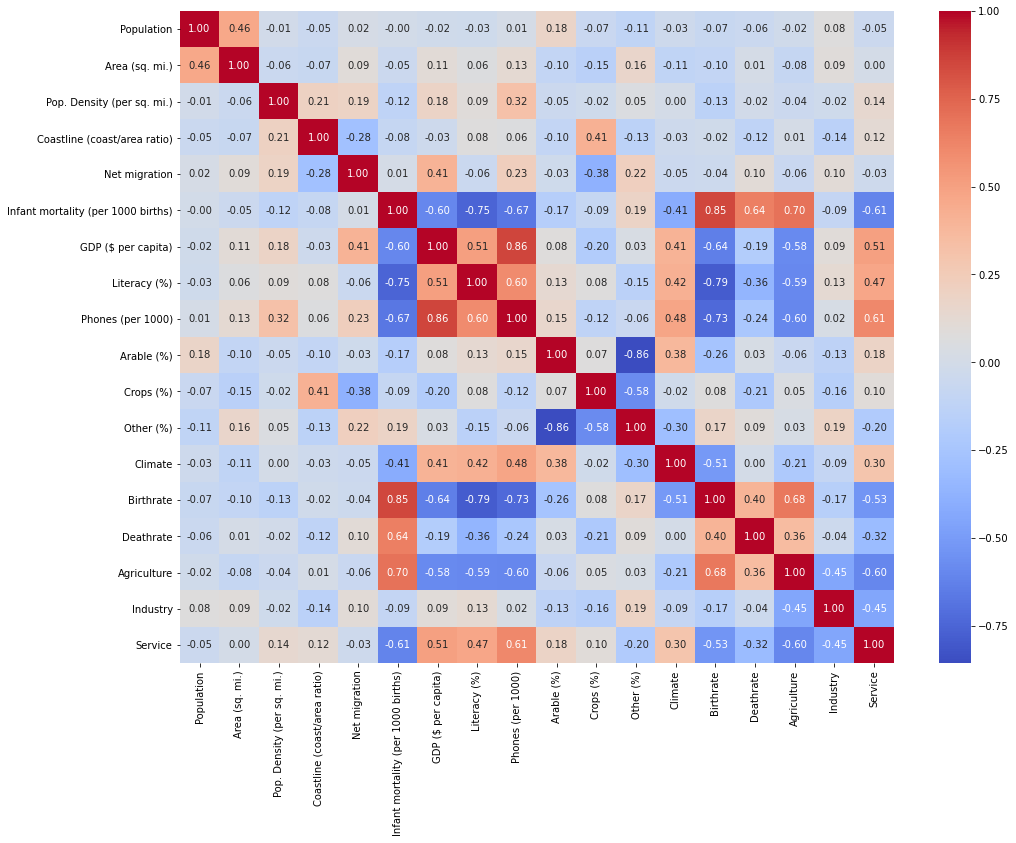

In [13]:
import seaborn as sns

plt.figure(figsize=(16,12))
sns.heatmap(data=df.iloc[:,1:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

In [14]:
num = set(df.columns.to_list()) - {'Country', 'GDP ($ per capita)', 'Climate'}

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\l

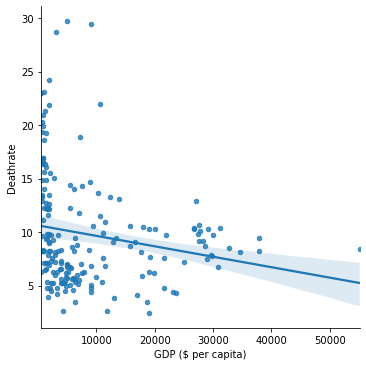

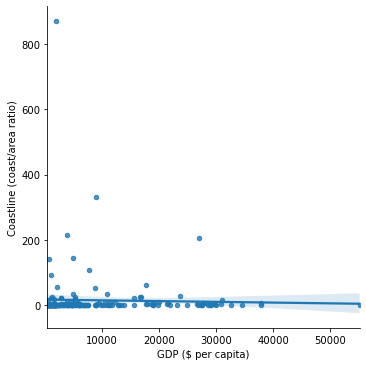

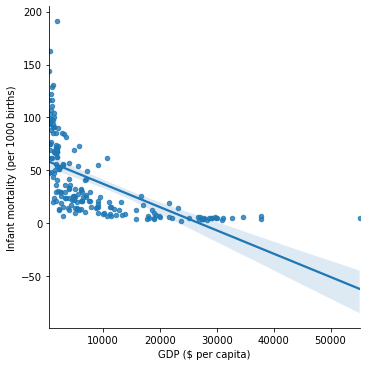

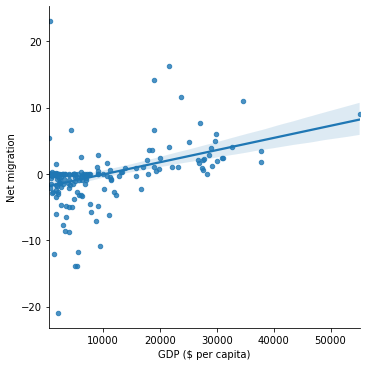

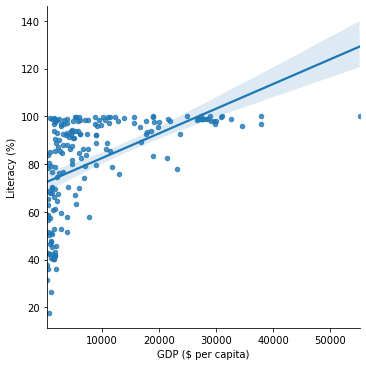

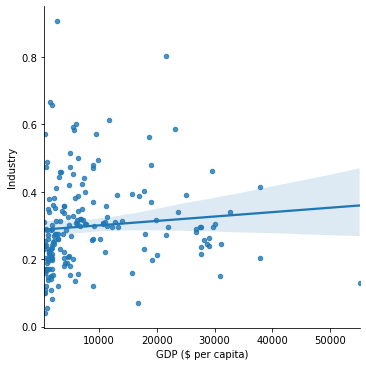

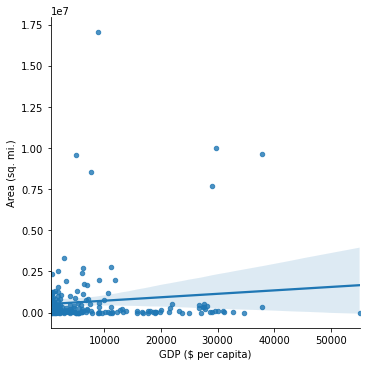

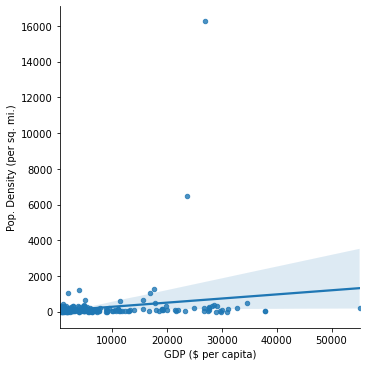

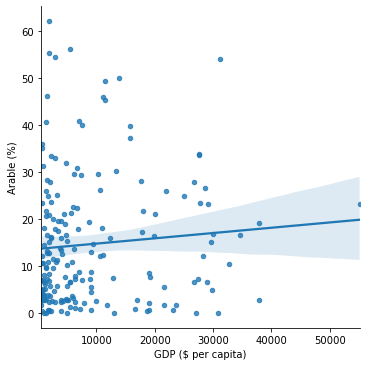

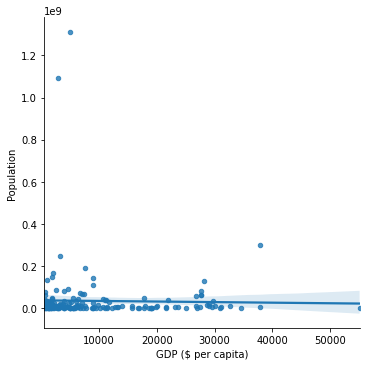

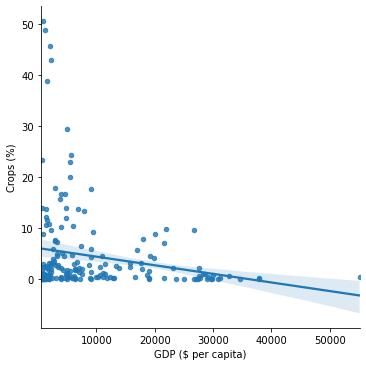

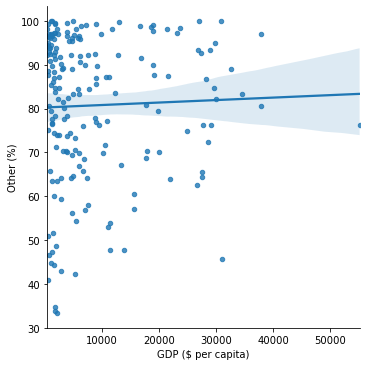

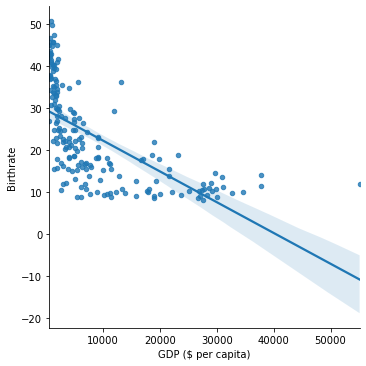

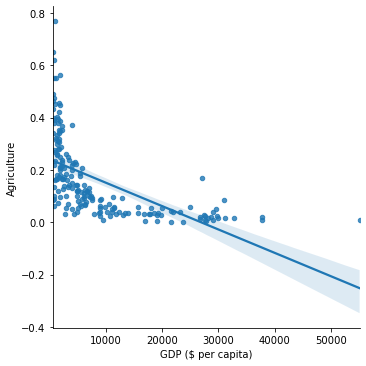

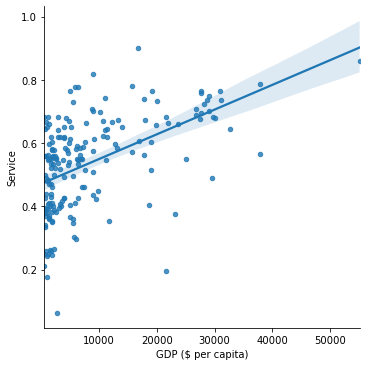

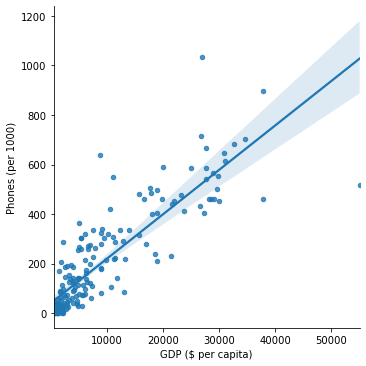

In [15]:
for n in num:
    sns.lmplot('GDP ($ per capita)', n, data=df, fit_reg=True, scatter_kws={"marker": "D", "s": 20})

array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>,
        <AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>],
       [<AxesSubplot:title={'center':'Net migration'}>,
        <AxesSubplot:title={'center':'Infant mortality (per 1000 births)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Phones (per 1000)'}>,
        <AxesSubplot:title={'center':'Arable (%)'}>,
        <AxesSubplot:title={'center':'Crops (%)'}>,
        <AxesSubplot:title={'center':'Other (%)'}>],
       [<AxesSubplot:title={'center':'Climate'}>,
        <AxesSubplot:title={'center':'Birthrate'}>,
        <AxesSubplot:title={'center':'Deathrate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>],
       [<AxesSubplot:title={'center':'Industry'}>,
        <AxesSubplot:

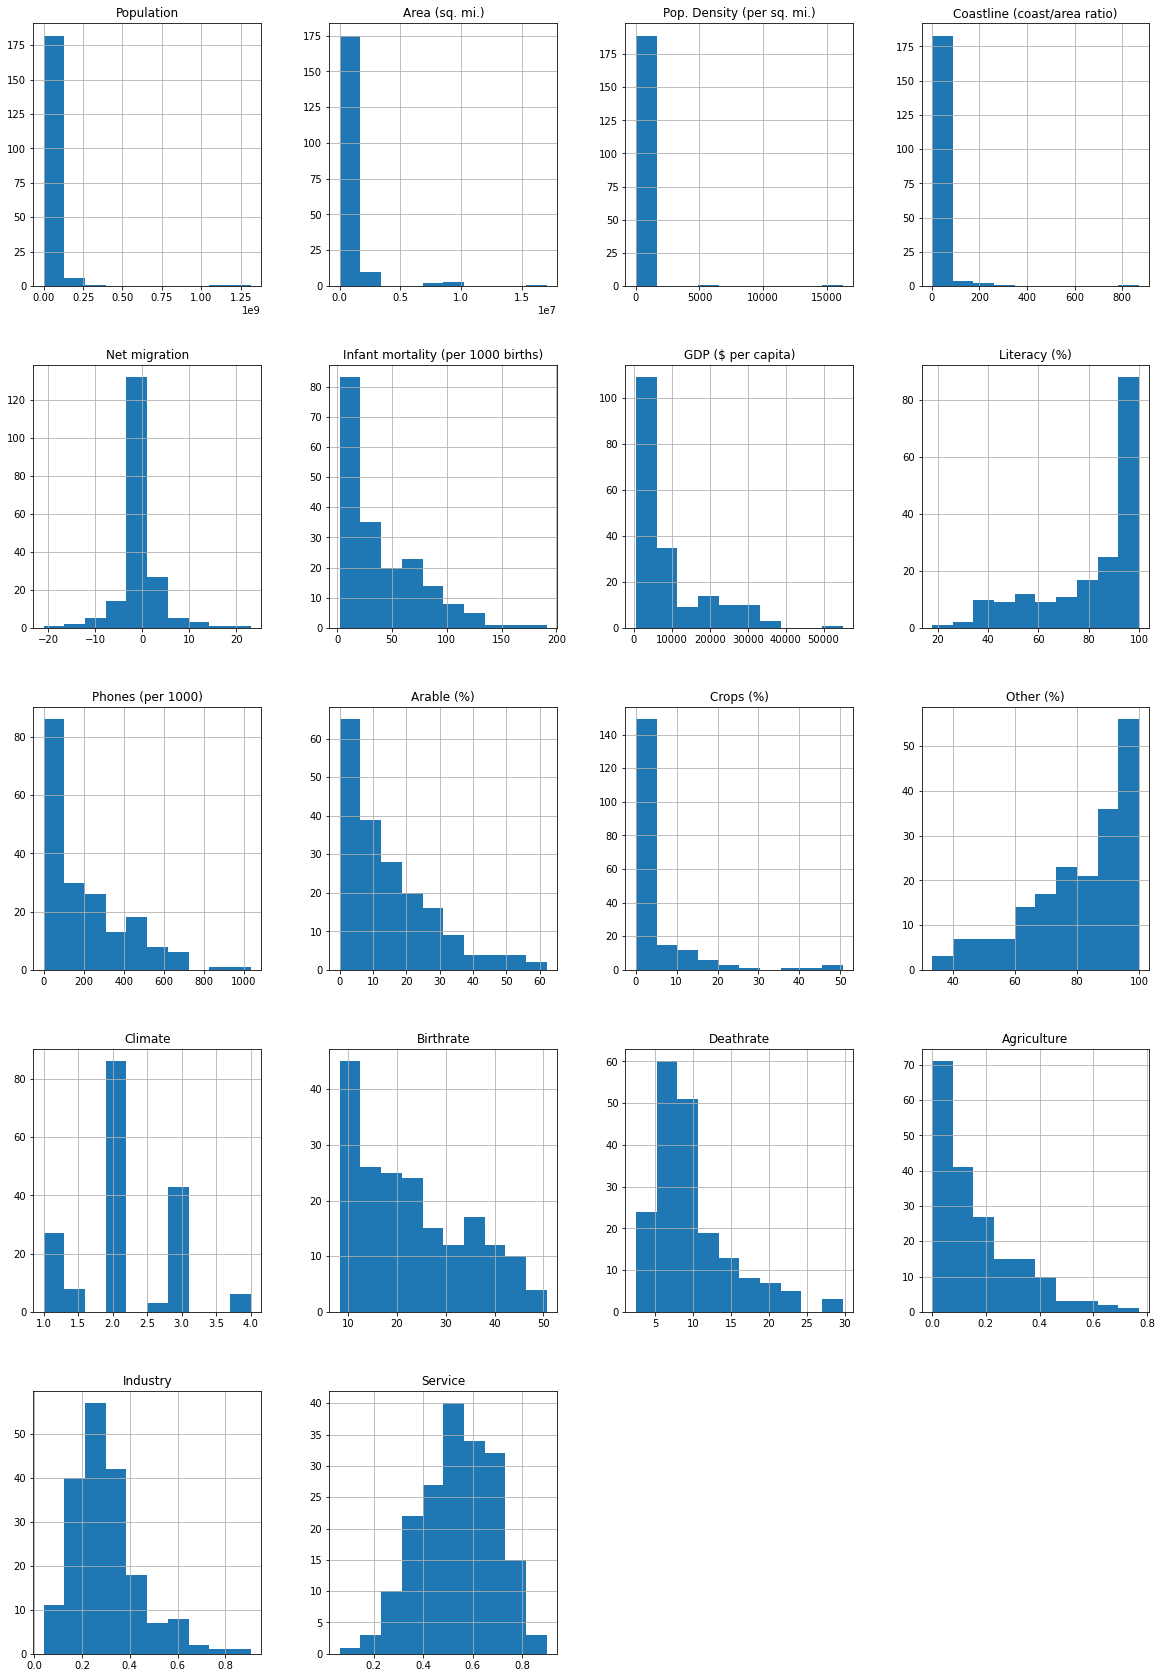

In [16]:
df.hist(figsize=(20,30))

In [17]:
df_filtered = df.copy()
df_filtered['Infant mortality (per 1000 births)'] = df['Infant mortality (per 1000 births)'].apply(np.log10)
# df_filtered['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log10)
df_filtered['Phones (per 1000)'] = df['Phones (per 1000)'].apply(np.log10)
# df_filtered['Arable (%)'] = df['Arable (%)'].apply(np.log10)
# df_filtered['Crops (%)'] = df['Crops (%)'].apply(np.log10)
# df_filtered['Coastline (coast/area ratio)'] = df['Coastline (coast/area ratio)'].apply(np.log10)
df_filtered['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(np.log10)
df_filtered['Other (%)'] = df['Other (%)'].apply(np.sqrt)
df_filtered['Literacy (%)'] = df['Literacy (%)'].apply(np.sqrt)


array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>,
        <AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>],
       [<AxesSubplot:title={'center':'Net migration'}>,
        <AxesSubplot:title={'center':'Infant mortality (per 1000 births)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Phones (per 1000)'}>,
        <AxesSubplot:title={'center':'Arable (%)'}>,
        <AxesSubplot:title={'center':'Crops (%)'}>,
        <AxesSubplot:title={'center':'Other (%)'}>],
       [<AxesSubplot:title={'center':'Climate'}>,
        <AxesSubplot:title={'center':'Birthrate'}>,
        <AxesSubplot:title={'center':'Deathrate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>],
       [<AxesSubplot:title={'center':'Industry'}>,
        <AxesSubplot:

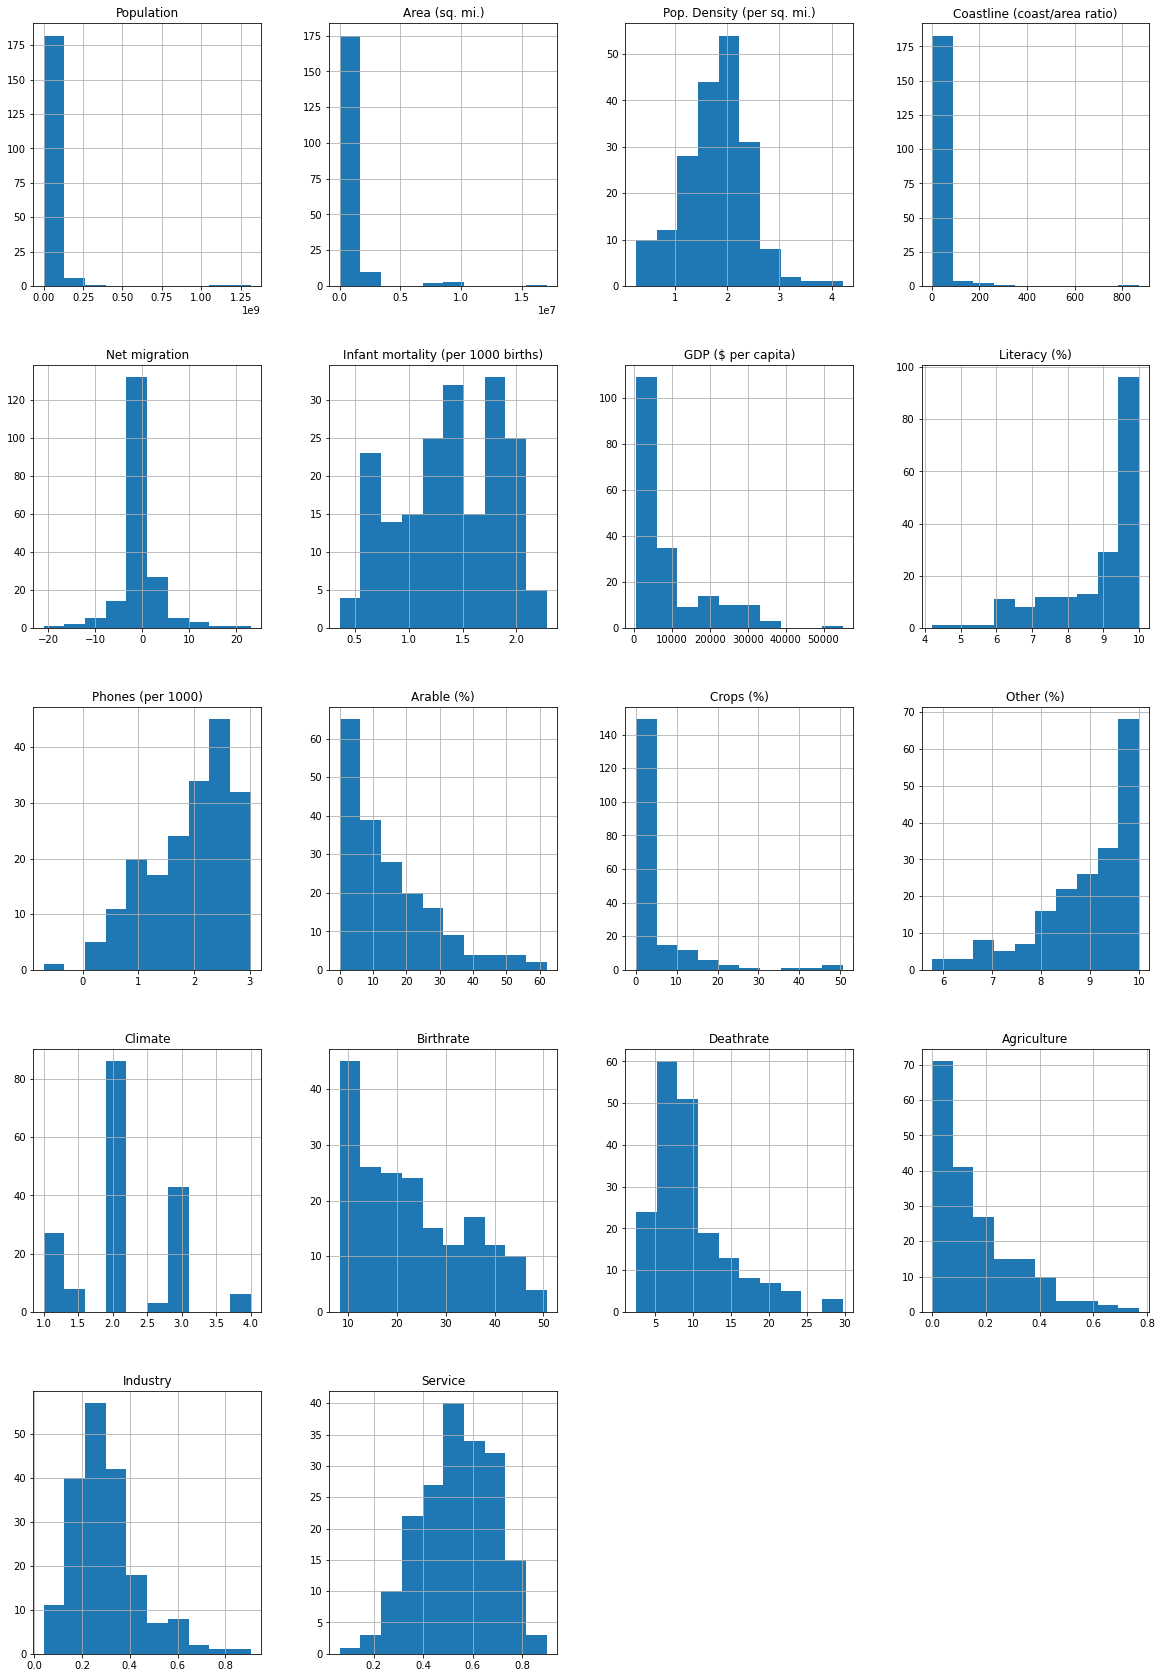

In [18]:
df_filtered.hist(figsize=(20,30))

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\l

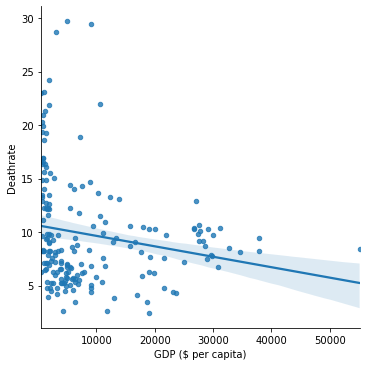

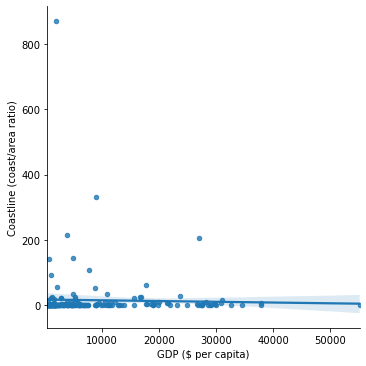

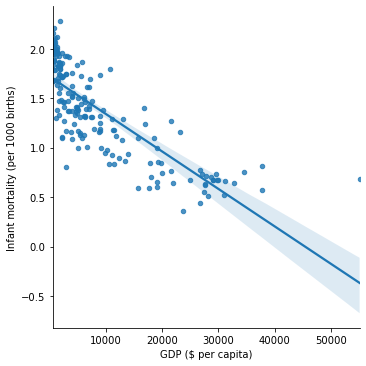

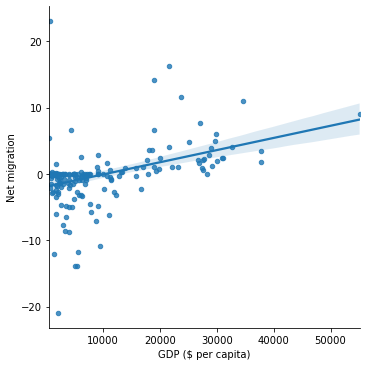

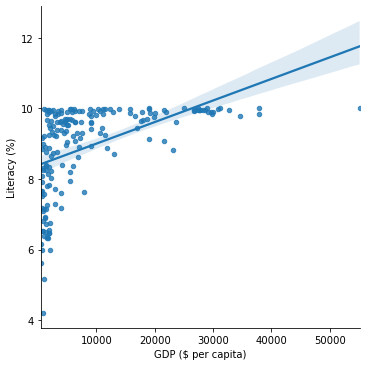

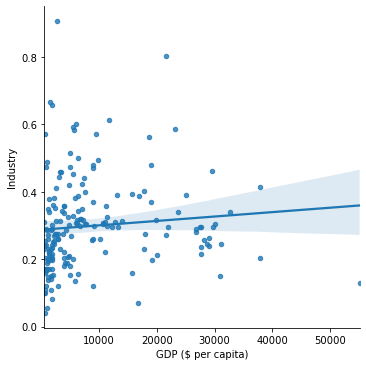

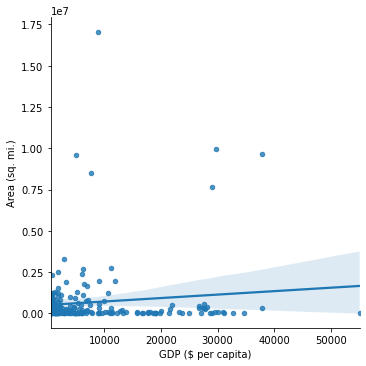

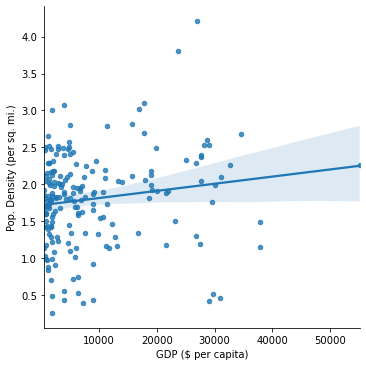

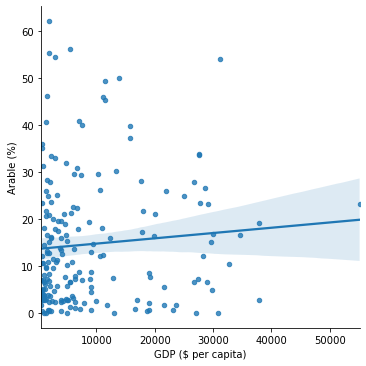

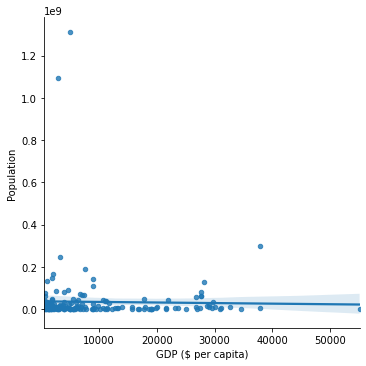

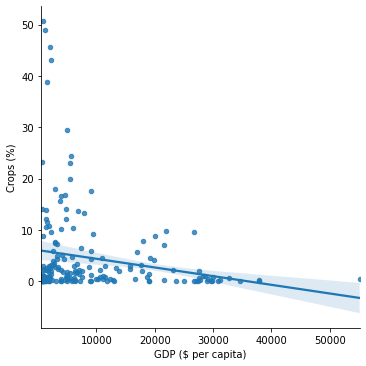

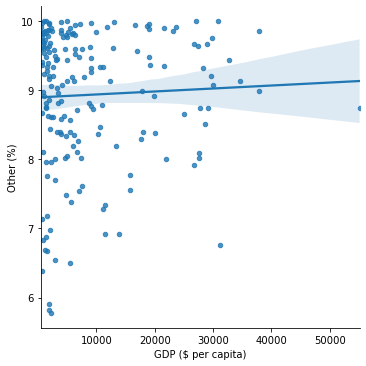

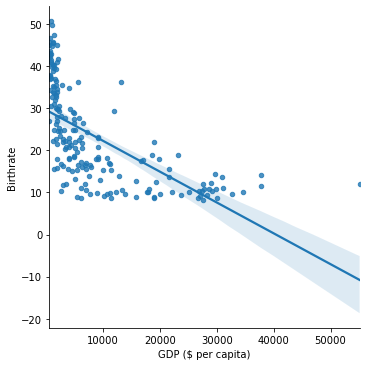

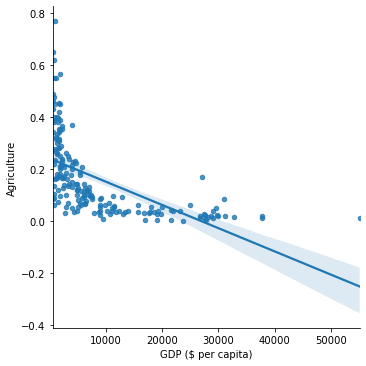

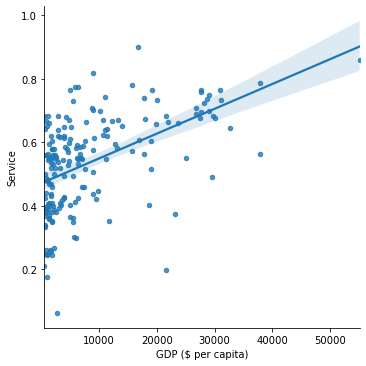

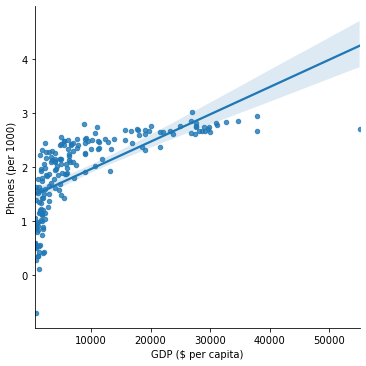

In [19]:
for n in num:
    sns.lmplot('GDP ($ per capita)', n, data=df_filtered, fit_reg=True, scatter_kws={"marker": "D", "s": 20})

<AxesSubplot:xlabel='GDP ($ per capita)'>

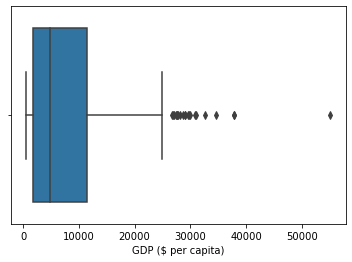

In [20]:
sns.boxplot(x=df_filtered["GDP ($ per capita)"])

In [21]:
df[df['GDP ($ per capita)'] < 2500].count()

Country                               67
Population                            67
Area (sq. mi.)                        67
Pop. Density (per sq. mi.)            67
Coastline (coast/area ratio)          67
Net migration                         67
Infant mortality (per 1000 births)    67
GDP ($ per capita)                    67
Literacy (%)                          64
Phones (per 1000)                     66
Arable (%)                            67
Crops (%)                             67
Other (%)                             67
Climate                               62
Birthrate                             66
Deathrate                             66
Agriculture                           67
Industry                              67
Service                               67
dtype: int64

In [22]:
# df_filtered['GDP ($ per capita)'] = df[df['GDP ($ per capita)'] < 2500].loc[:, 'GDP ($ per capita)']

<AxesSubplot:ylabel='Frequency'>

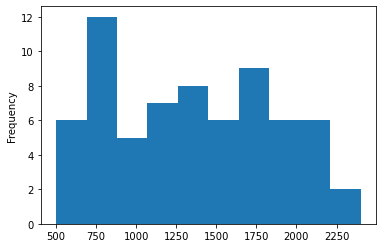

In [23]:
df[df['GDP ($ per capita)'] < 2500].loc[:, 'GDP ($ per capita)'].plot.hist()

In [24]:
df_test = df_filtered.copy()

class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T

191


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),1.68124,2.09552,1.13988,2.18213,0.986772
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),2.21237,1.33284,1.49136,0.607455,2.28147
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),6,9.30054,8.3666,10,6.48074
Phones (per 1000),0.50515,1.85248,1.89265,2.69653,0.892095


In [25]:
# df.isna().sum()
df_test=df_test.dropna()   ### Só para testar por enquanto


In [26]:
df_test.shape

(163, 20)

In [27]:
# ###### Pré processamento inicial (para testar o tutorial)

# df_test["Has coastline"] = df_test['Coastline (coast/area ratio)'].apply(lambda x: 0 if x == 0 else 1)

# ##### Pra esses 3 poderia pegar o maior para cada país
# # df_test["Industrial"] = df_test['Industry'].apply(lambda x: 0 if x <0.16 else 1)
# # df_test["Agricultural"] = df_test['Agriculture'].apply(lambda x: 0 if x <0.3 else 1)
# # df_test["Services"] = df_test['Service'].apply(lambda x: 0 if x <0.5 else 1)

# # df_test['Industrial']=0
# # df_test['Agricultural']=0
# # df_test['Services']=0

# df_test['Industrial'] = np.where((df_test['Agriculture'] <= df_test['Industry']) & (df_test['Service'] <= df_test['Industry']), 1,0)
# df_test['Agricultural'] = np.where((df_test['Industry'] <= df_test['Agriculture']) & (df_test['Service'] <= df_test['Agriculture']), 1,0)
# df_test['Services'] = np.where((df_test['Agriculture'] <= df_test['Service']) & (df_test['Industry'] <= df_test['Service']), 1,0)


# df_test["High Literacy"] = df_test['Literacy (%)'].apply(lambda x: 0 if x <0.9 else 1)

# ## Usar OneHotEncoder para as Climate

# # est = KBinsDiscretizer(n_bins=4, encode='ordinal', 
# #                        strategy='quantile')
# # df_test['GDP'] = est.fit_transform(df_test[['GDP ($ per capita)'])


df_test['GDP'] =df_test['GDP ($ per capita)']

#### Mudar essa classificacao para https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2020-2021

# df_test['POP_1'] = df_test['Population'].apply(lambda x: 0 if x == 0 else 1)
# df_test['POP_2']
# df_test['POP_3']
# df_test['POP_4']




df_test.drop(['GDP ($ per capita)'], axis=1, inplace=True)
df_test.T


,0,1,2,7,8,9,11,12,13,14,...,213,214,215,216,217,218,219,224,225,226
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Population,31056997,3581655,32930091,69108,39921833,2976372,20264082,8192880,7961619,303770,...,60609153,298444215,3431932,27307134,208869,25730435,84402966,21456188,11502010,12236805
Area (sq. mi.),647500,28748,2381740,443,2766890,29800,7686850,83870,86600,13940,...,244820,9631420,176220,447400,12200,912050,329560,527970,752614,390580
Pop. Density (per sq. mi.),1.68124,2.09552,1.13988,2.19312,1.15836,1.99957,0.414973,1.98989,1.96332,1.33846,...,2.39375,1.49136,1.29003,1.78533,1.233,1.45025,2.40841,1.60853,1.18469,1.49554
Coastline (coast/area ratio),0,1.26,0.04,34.54,0.18,0,0.34,0,0,25.41,...,5.08,0.21,0.37,0,20.72,0.31,1.05,0.36,0,0
Net migration,23.06,-4.93,-0.39,-6.15,0.61,-6.47,3.98,2,-4.9,-2.2,...,2.19,3.41,-0.32,-1.72,0,-0.04,-0.45,0,0,0
Infant mortality (per 1000 births),2.21237,1.33284,1.49136,1.28914,1.18127,1.36698,0.671173,0.668386,1.91243,1.40157,...,0.71265,0.812913,1.07737,1.85187,1.74162,1.34635,1.41414,1.78888,1.94591,1.83052
Literacy (%),6,9.30054,8.3666,9.43398,9.85393,9.92975,10,9.89949,9.84886,9.77753,...,9.94987,9.84886,9.89949,9.96494,7.28011,9.66437,9.50263,7.0852,8.97775,9.52365
Phones (per 1000),0.50515,1.85248,1.89265,2.74028,2.34321,2.29159,2.75243,2.65533,2.13704,2.66332,...,2.7352,2.95328,2.46449,1.79865,1.51322,2.14644,2.27346,1.57054,0.913814,1.42813
Arable (%),12.13,21.09,3.22,18.18,12.31,17.55,6.55,16.91,19.63,0.8,...,23.46,19.13,7.43,10.83,2.46,2.95,19.97,2.78,7.08,8.32


In [28]:
df.Population.describe()

count    1.910000e+02
mean     3.393533e+07
std      1.278974e+08
min      1.181000e+04
25%      1.640698e+06
50%      7.320815e+06
75%      2.235656e+07
max      1.313974e+09
Name: Population, dtype: float64

In [29]:
df_test.GDP


0        700.0
1       4500.0
2       6000.0
7      11000.0
8      11200.0
        ...   
218     4800.0
219     2500.0
224      800.0
225      800.0
226     1900.0
Name: GDP, Length: 163, dtype: float64

In [30]:
existing_countries = df_test.Country.to_list()

In [31]:
edges = []
# src=[]
# tar=[]
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
#         if n['source'] not in src:
#             src.append(n['source'])
            
#         if n['target'] not in tar:
#             tar.append(n['target'])
        edges.append((n['source'], n['target']))
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])
df_edges.head(5).T



,0,1,2,3,4
source,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
target,People's Republic of China,Iran,Pakistan,Tajikistan,Turkmenistan


In [32]:
df_edges.shape

(226, 2)

#### Visualizando como um grafo

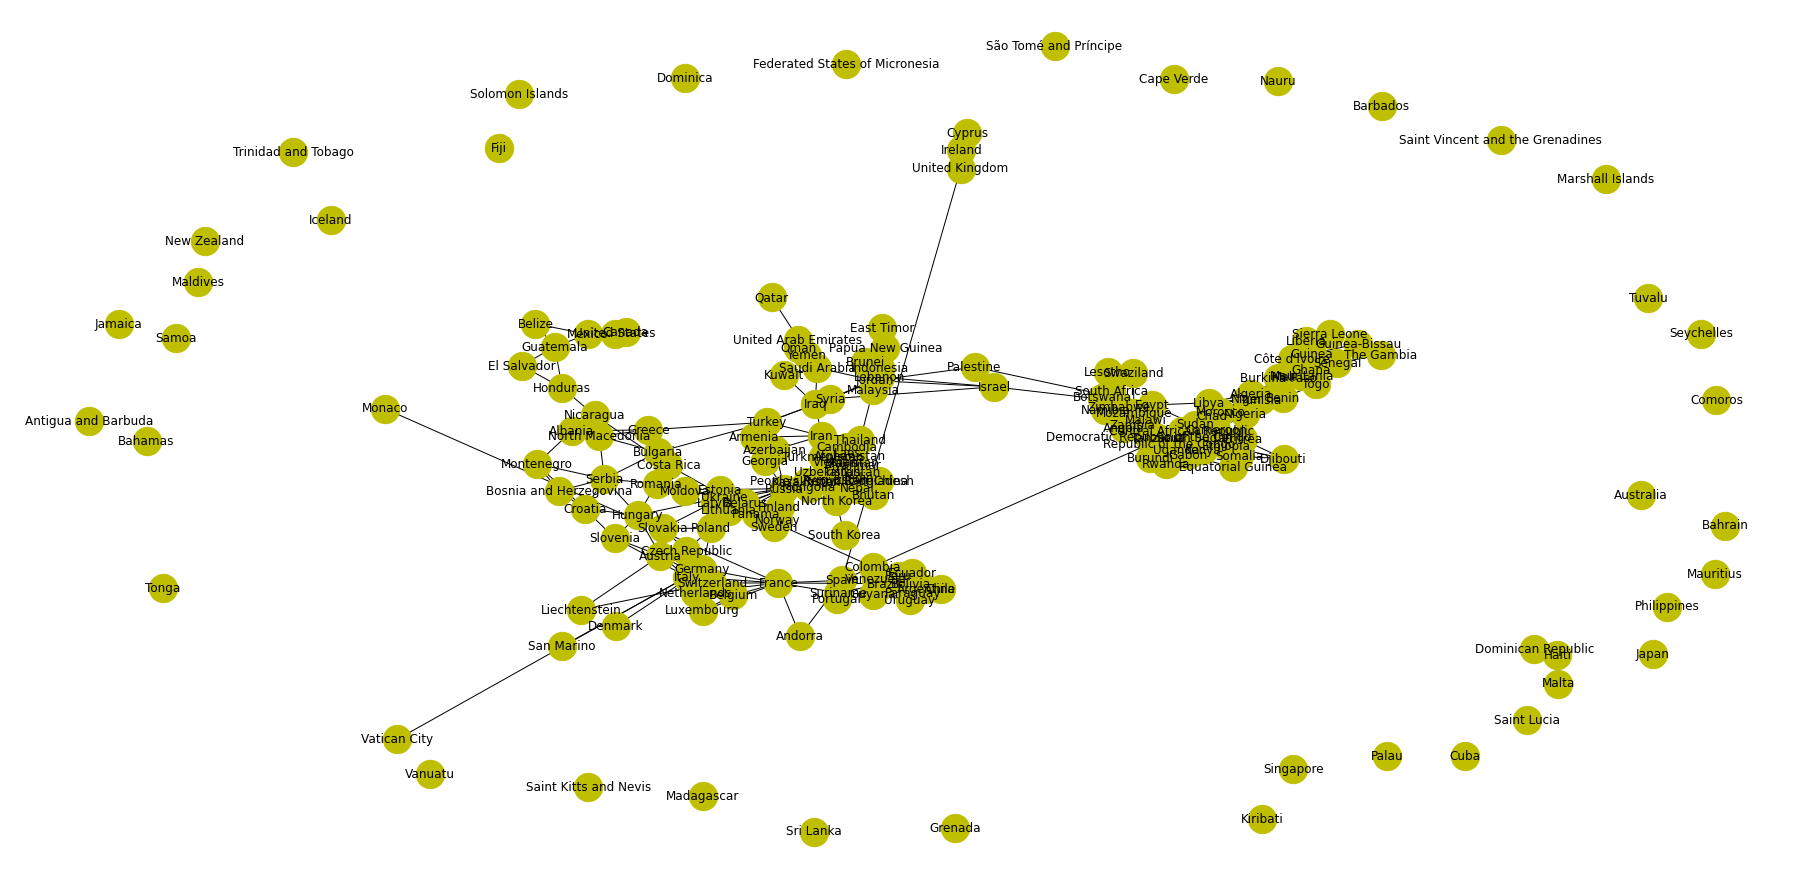

In [33]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='y')
plt.show()
# plt.savefig("graph.png", dpi=1000)

#### Transformando os nodes em valores numéricos

In [34]:
class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T


163


,0,1,2,7,8
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina
Population,31056997,3581655,32930091,69108,39921833
Area (sq. mi.),647500,28748,2381740,443,2766890
Pop. Density (per sq. mi.),1.68124,2.09552,1.13988,2.19312,1.15836
Coastline (coast/area ratio),0,1.26,0.04,34.54,0.18
Net migration,23.06,-4.93,-0.39,-6.15,0.61
Infant mortality (per 1000 births),2.21237,1.33284,1.49136,1.28914,1.18127
Literacy (%),6,9.30054,8.3666,9.43398,9.85393
Phones (per 1000),0.50515,1.85248,1.89265,2.74028,2.34321
Arable (%),12.13,21.09,3.22,18.18,12.31


In [35]:
df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [36]:
df_edges.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
source,0,0,0,0,0,0,1,2,2,2,2,4,4,4,4,4,5,5,5,5
target,111,69,106,141,149,156,57,89,91,101,147,18,20,30,110,155,8,54,69,148


# Montando o classificador
https://keras.io/examples/graph/gnn_citations/


In [37]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = num_features
print(num_features, num_classes)

17 17


### Separando treino e teste

In [38]:
df_test.T

,0,1,2,7,8,9,11,12,13,14,...,213,214,215,216,217,218,219,224,225,226
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Population,31056997,3581655,32930091,69108,39921833,2976372,20264082,8192880,7961619,303770,...,60609153,298444215,3431932,27307134,208869,25730435,84402966,21456188,11502010,12236805
Area (sq. mi.),647500,28748,2381740,443,2766890,29800,7686850,83870,86600,13940,...,244820,9631420,176220,447400,12200,912050,329560,527970,752614,390580
Pop. Density (per sq. mi.),1.68124,2.09552,1.13988,2.19312,1.15836,1.99957,0.414973,1.98989,1.96332,1.33846,...,2.39375,1.49136,1.29003,1.78533,1.233,1.45025,2.40841,1.60853,1.18469,1.49554
Coastline (coast/area ratio),0,1.26,0.04,34.54,0.18,0,0.34,0,0,25.41,...,5.08,0.21,0.37,0,20.72,0.31,1.05,0.36,0,0
Net migration,23.06,-4.93,-0.39,-6.15,0.61,-6.47,3.98,2,-4.9,-2.2,...,2.19,3.41,-0.32,-1.72,0,-0.04,-0.45,0,0,0
Infant mortality (per 1000 births),2.21237,1.33284,1.49136,1.28914,1.18127,1.36698,0.671173,0.668386,1.91243,1.40157,...,0.71265,0.812913,1.07737,1.85187,1.74162,1.34635,1.41414,1.78888,1.94591,1.83052
Literacy (%),6,9.30054,8.3666,9.43398,9.85393,9.92975,10,9.89949,9.84886,9.77753,...,9.94987,9.84886,9.89949,9.96494,7.28011,9.66437,9.50263,7.0852,8.97775,9.52365
Phones (per 1000),0.50515,1.85248,1.89265,2.74028,2.34321,2.29159,2.75243,2.65533,2.13704,2.66332,...,2.7352,2.95328,2.46449,1.79865,1.51322,2.14644,2.27346,1.57054,0.913814,1.42813
Arable (%),12.13,21.09,3.22,18.18,12.31,17.55,6.55,16.91,19.63,0.8,...,23.46,19.13,7.43,10.83,2.46,2.95,19.97,2.78,7.08,8.32


In [39]:
df_test.GDP.describe()

count      163.000000
mean      8227.607362
std       9203.711599
min        500.000000
25%       1700.000000
50%       4600.000000
75%      10850.000000
max      37800.000000
Name: GDP, dtype: float64

In [40]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.55
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (97, 20)
Test data shape: (66, 20)


In [41]:
# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["GDP"]
y_test = test_data["GDP"]

In [42]:
x_train.shape

(97, 17)

In [43]:
def model_predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    train_pred_Y = model.predict(x_train)
    test_pred_Y = model.predict(x_test)
    train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=y_train.index)
    test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=y_test.index)


    rmse_train = np.sqrt(mean_squared_error(train_pred_Y, y_train))
    msle_train = mean_squared_log_error(train_pred_Y, y_train)
    rmse_test = np.sqrt(mean_squared_error(test_pred_Y, y_test))
    msle_test = mean_squared_log_error(test_pred_Y, y_test)

    print('rmse_train:',rmse_train,'msle_train:',msle_train)
    print('rmse_test:',rmse_test,'msle_test:',msle_test)

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [45]:
model = LinearRegression()
model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 3697.5475624865226 msle_train: 6.9956052968274465
rmse_test: 3816.101218881345 msle_test: 14.133923101140974


In [46]:
model = RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 2079.304642569816 msle_train: 0.06939783429145449
rmse_test: 2930.73159506528 msle_test: 0.4399227225150693


In [47]:
model = DecisionTreeRegressor(max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 2350.596633369853 msle_train: 0.06870941555750101
rmse_test: 4044.271411285225 msle_test: 0.4341389035216592


### Testando um modelo baseline 
(Ainda não leva em consideração as conexões do grafo)

In [48]:
##  Feedforward Network (FFN) Module
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [49]:
def create_simple_model(num_classes):
    model = keras.Sequential([
        layers.Dense(1, input_shape=[num_classes]),
        #layers.Dense(5, activation='selu', input_shape=[5]),
        #layers.Dense(1),
    ])
    return model
    
baseline_model = create_simple_model(num_classes)

In [50]:
def create_simple_model(num_classes):
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[num_classes]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
    return model
    
baseline_model = create_simple_model(num_classes)

In [51]:
def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-1),
        loss='mse',
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=2000,
        batch_size=2048,
        validation_split=0.3,
    )

    return history

In [52]:
def display_learning_curves(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    plt.show()

In [53]:
# def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
#     inputs = layers.Input(shape=(num_features,), name="input_features")
#     x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
#     for block_idx in range(4):
#         # Create an FFN block.
#         x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
#         # Add skip connection.
#         x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
#     # Compute logits.
#     logits = layers.Dense(num_classes, name="logits")(x)
#     # Create the model.
#     return keras.Model(inputs=inputs, outputs=logits, name="baseline")


# baseline_model = create_baseline_model( [32, 32], num_classes,  0.2)
# baseline_model.summary()

In [54]:
# baseline_model = RandomForestRegressor(n_estimators = 50,
#                              max_depth = 6,
#                              min_weight_fraction_leaf = 0.05,
#                              max_features = 0.8,
#                              random_state = 42)

In [55]:
# baseline_model = create_ffn([32,32],0.2)

In [56]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/2000
1/1 [==============================] - 1s 669ms/step - loss: 150004803043328.0000 - val_loss: 33950266923417600.0000
Epoch 2/2000
1/1 [==============================] - 0s 36ms/step - loss: 668200016795402240.0000 - val_loss: 1260675175284736.0000
Epoch 3/2000
1/1 [==============================] - 0s 35ms/step - loss: 24807881425551360.0000 - val_loss: 559471198208.0000
Epoch 4/2000
1/1 [==============================] - 0s 42ms/step - loss: 10871625482240.0000 - val_loss: 6794808655872.0000
Epoch 5/2000
1/1 [==============================] - 0s 39ms/step - loss: 134239949422592.0000 - val_loss: 5244946743296.0000
Epoch 6/2000
1/1 [==============================] - 0s 39ms/step - loss: 103691122114560.0000 - val_loss: 1021923164160.0000
Epoch 7/2000
1/1 [==============================] - 0s 31ms/step - loss: 20311883907072.0000 - val_loss: 73866297344.0000
Epoch 8/2000
1/1 [==============================] - 0s 33ms/step - loss: 1406623154176.0000 - val_loss: 43254460416.0

Epoch 71/2000
1/1 [==============================] - 0s 36ms/step - loss: 159315040.0000 - val_loss: 170673296.0000
Epoch 72/2000
1/1 [==============================] - 0s 28ms/step - loss: 159310896.0000 - val_loss: 170669152.0000
Epoch 73/2000
1/1 [==============================] - 0s 28ms/step - loss: 159306736.0000 - val_loss: 170665008.0000
Epoch 74/2000
1/1 [==============================] - 0s 30ms/step - loss: 159302560.0000 - val_loss: 170660864.0000
Epoch 75/2000
1/1 [==============================] - 0s 28ms/step - loss: 159298416.0000 - val_loss: 170656736.0000
Epoch 76/2000
1/1 [==============================] - 0s 29ms/step - loss: 159294288.0000 - val_loss: 170652592.0000
Epoch 77/2000
1/1 [==============================] - 0s 34ms/step - loss: 159290144.0000 - val_loss: 170648464.0000
Epoch 78/2000
1/1 [==============================] - 0s 32ms/step - loss: 159286000.0000 - val_loss: 170644336.0000
Epoch 79/2000
1/1 [==============================] - 0s 40ms/step - loss

1/1 [==============================] - 0s 30ms/step - loss: 159028752.0000 - val_loss: 170387568.0000
Epoch 142/2000
1/1 [==============================] - 0s 30ms/step - loss: 159024704.0000 - val_loss: 170383552.0000
Epoch 143/2000
1/1 [==============================] - 0s 41ms/step - loss: 159020688.0000 - val_loss: 170379488.0000
Epoch 144/2000
1/1 [==============================] - 0s 35ms/step - loss: 159016624.0000 - val_loss: 170375472.0000
Epoch 145/2000
1/1 [==============================] - 0s 37ms/step - loss: 159012576.0000 - val_loss: 170371424.0000
Epoch 146/2000
1/1 [==============================] - 0s 33ms/step - loss: 159008528.0000 - val_loss: 170367376.0000
Epoch 147/2000
1/1 [==============================] - 0s 27ms/step - loss: 159004496.0000 - val_loss: 170363344.0000
Epoch 148/2000
1/1 [==============================] - 0s 25ms/step - loss: 159000432.0000 - val_loss: 170359312.0000
Epoch 149/2000
1/1 [==============================] - 0s 27ms/step - loss: 1589

1/1 [==============================] - 0s 27ms/step - loss: 158746688.0000 - val_loss: 170106000.0000
Epoch 212/2000
1/1 [==============================] - 0s 35ms/step - loss: 158742672.0000 - val_loss: 170101968.0000
Epoch 213/2000
1/1 [==============================] - 0s 26ms/step - loss: 158738656.0000 - val_loss: 170097952.0000
Epoch 214/2000
1/1 [==============================] - 0s 27ms/step - loss: 158734624.0000 - val_loss: 170093968.0000
Epoch 215/2000
1/1 [==============================] - 0s 30ms/step - loss: 158730640.0000 - val_loss: 170089936.0000
Epoch 216/2000
1/1 [==============================] - 0s 27ms/step - loss: 158726608.0000 - val_loss: 170085952.0000
Epoch 217/2000
1/1 [==============================] - 0s 26ms/step - loss: 158722592.0000 - val_loss: 170081936.0000
Epoch 218/2000
1/1 [==============================] - 0s 27ms/step - loss: 158718576.0000 - val_loss: 170077952.0000
Epoch 219/2000
1/1 [==============================] - 0s 29ms/step - loss: 1587

1/1 [==============================] - 0s 29ms/step - loss: 158466272.0000 - val_loss: 169826048.0000
Epoch 282/2000
1/1 [==============================] - 0s 29ms/step - loss: 158462288.0000 - val_loss: 169822048.0000
Epoch 283/2000
1/1 [==============================] - 0s 28ms/step - loss: 158458288.0000 - val_loss: 169818080.0000
Epoch 284/2000
1/1 [==============================] - 0s 27ms/step - loss: 158454288.0000 - val_loss: 169814048.0000
Epoch 285/2000
1/1 [==============================] - 0s 28ms/step - loss: 158450288.0000 - val_loss: 169810096.0000
Epoch 286/2000
1/1 [==============================] - 0s 31ms/step - loss: 158446288.0000 - val_loss: 169806096.0000
Epoch 287/2000
1/1 [==============================] - 0s 34ms/step - loss: 158442320.0000 - val_loss: 169802096.0000
Epoch 288/2000
1/1 [==============================] - 0s 36ms/step - loss: 158438288.0000 - val_loss: 169798112.0000
Epoch 289/2000
1/1 [==============================] - 0s 30ms/step - loss: 1584

1/1 [==============================] - 0s 26ms/step - loss: 158186880.0000 - val_loss: 169547088.0000
Epoch 352/2000
1/1 [==============================] - 0s 30ms/step - loss: 158182880.0000 - val_loss: 169543136.0000
Epoch 353/2000
1/1 [==============================] - 0s 26ms/step - loss: 158178896.0000 - val_loss: 169539120.0000
Epoch 354/2000
1/1 [==============================] - 0s 32ms/step - loss: 158174912.0000 - val_loss: 169535168.0000
Epoch 355/2000
1/1 [==============================] - 0s 26ms/step - loss: 158170944.0000 - val_loss: 169531168.0000
Epoch 356/2000
1/1 [==============================] - 0s 23ms/step - loss: 158166928.0000 - val_loss: 169527216.0000
Epoch 357/2000
1/1 [==============================] - 0s 26ms/step - loss: 158162960.0000 - val_loss: 169523216.0000
Epoch 358/2000
1/1 [==============================] - 0s 26ms/step - loss: 158158976.0000 - val_loss: 169519264.0000
Epoch 359/2000
1/1 [==============================] - 0s 25ms/step - loss: 1581

1/1 [==============================] - 0s 27ms/step - loss: 157908144.0000 - val_loss: 169268784.0000
Epoch 422/2000
1/1 [==============================] - 0s 38ms/step - loss: 157904128.0000 - val_loss: 169264832.0000
Epoch 423/2000
1/1 [==============================] - 0s 28ms/step - loss: 157900176.0000 - val_loss: 169260848.0000
Epoch 424/2000
1/1 [==============================] - 0s 31ms/step - loss: 157896192.0000 - val_loss: 169256896.0000
Epoch 425/2000
1/1 [==============================] - 0s 30ms/step - loss: 157892208.0000 - val_loss: 169252896.0000
Epoch 426/2000
1/1 [==============================] - 0s 26ms/step - loss: 157888224.0000 - val_loss: 169248960.0000
Epoch 427/2000
1/1 [==============================] - 0s 27ms/step - loss: 157884256.0000 - val_loss: 169244976.0000
Epoch 428/2000
1/1 [==============================] - 0s 26ms/step - loss: 157880272.0000 - val_loss: 169241008.0000
Epoch 429/2000
1/1 [==============================] - 0s 24ms/step - loss: 1578

1/1 [==============================] - 0s 25ms/step - loss: 157629792.0000 - val_loss: 168990912.0000
Epoch 492/2000
1/1 [==============================] - 0s 28ms/step - loss: 157625824.0000 - val_loss: 168986944.0000
Epoch 493/2000
1/1 [==============================] - 0s 25ms/step - loss: 157621840.0000 - val_loss: 168982992.0000
Epoch 494/2000
1/1 [==============================] - 0s 26ms/step - loss: 157617888.0000 - val_loss: 168979008.0000
Epoch 495/2000
1/1 [==============================] - 0s 29ms/step - loss: 157613904.0000 - val_loss: 168975040.0000
Epoch 496/2000
1/1 [==============================] - 0s 24ms/step - loss: 157609920.0000 - val_loss: 168971088.0000
Epoch 497/2000
1/1 [==============================] - 0s 25ms/step - loss: 157605952.0000 - val_loss: 168967104.0000
Epoch 498/2000
1/1 [==============================] - 0s 25ms/step - loss: 157601968.0000 - val_loss: 168963136.0000
Epoch 499/2000
1/1 [==============================] - 0s 26ms/step - loss: 1575

1/1 [==============================] - 0s 45ms/step - loss: 157351648.0000 - val_loss: 168713216.0000
Epoch 562/2000
1/1 [==============================] - 0s 30ms/step - loss: 157347680.0000 - val_loss: 168709280.0000
Epoch 563/2000
1/1 [==============================] - 0s 27ms/step - loss: 157343712.0000 - val_loss: 168705312.0000
Epoch 564/2000
1/1 [==============================] - 0s 27ms/step - loss: 157339744.0000 - val_loss: 168701344.0000
Epoch 565/2000
1/1 [==============================] - 0s 26ms/step - loss: 157335760.0000 - val_loss: 168697376.0000
Epoch 566/2000
1/1 [==============================] - 0s 25ms/step - loss: 157331808.0000 - val_loss: 168693424.0000
Epoch 567/2000
1/1 [==============================] - 0s 26ms/step - loss: 157327824.0000 - val_loss: 168689440.0000
Epoch 568/2000
1/1 [==============================] - 0s 26ms/step - loss: 157323856.0000 - val_loss: 168685488.0000
Epoch 569/2000
1/1 [==============================] - 0s 25ms/step - loss: 1573

1/1 [==============================] - 0s 24ms/step - loss: 157073536.0000 - val_loss: 168435552.0000
Epoch 632/2000
1/1 [==============================] - 0s 23ms/step - loss: 157069584.0000 - val_loss: 168431600.0000
Epoch 633/2000
1/1 [==============================] - 0s 24ms/step - loss: 157065600.0000 - val_loss: 168427616.0000
Epoch 634/2000
1/1 [==============================] - 0s 25ms/step - loss: 157061632.0000 - val_loss: 168423664.0000
Epoch 635/2000
1/1 [==============================] - 0s 26ms/step - loss: 157057632.0000 - val_loss: 168419680.0000
Epoch 636/2000
1/1 [==============================] - 0s 27ms/step - loss: 157053664.0000 - val_loss: 168415728.0000
Epoch 637/2000
1/1 [==============================] - 0s 29ms/step - loss: 157049696.0000 - val_loss: 168411744.0000
Epoch 638/2000
1/1 [==============================] - 0s 23ms/step - loss: 157045728.0000 - val_loss: 168407808.0000
Epoch 639/2000
1/1 [==============================] - 0s 26ms/step - loss: 1570

1/1 [==============================] - 0s 26ms/step - loss: 156795232.0000 - val_loss: 168157696.0000
Epoch 702/2000
1/1 [==============================] - 0s 23ms/step - loss: 156791264.0000 - val_loss: 168153712.0000
Epoch 703/2000
1/1 [==============================] - 0s 26ms/step - loss: 156787280.0000 - val_loss: 168149760.0000
Epoch 704/2000
1/1 [==============================] - 0s 24ms/step - loss: 156783312.0000 - val_loss: 168145776.0000
Epoch 705/2000
1/1 [==============================] - 0s 22ms/step - loss: 156779328.0000 - val_loss: 168141792.0000
Epoch 706/2000
1/1 [==============================] - 0s 29ms/step - loss: 156775328.0000 - val_loss: 168137824.0000
Epoch 707/2000
1/1 [==============================] - 0s 29ms/step - loss: 156771344.0000 - val_loss: 168133856.0000
Epoch 708/2000
1/1 [==============================] - 0s 26ms/step - loss: 156767392.0000 - val_loss: 168129888.0000
Epoch 709/2000
1/1 [==============================] - 0s 26ms/step - loss: 1567

1/1 [==============================] - 0s 37ms/step - loss: 156516512.0000 - val_loss: 167879424.0000
Epoch 772/2000
1/1 [==============================] - 0s 31ms/step - loss: 156512528.0000 - val_loss: 167875440.0000
Epoch 773/2000
1/1 [==============================] - 0s 31ms/step - loss: 156508528.0000 - val_loss: 167871472.0000
Epoch 774/2000
1/1 [==============================] - 0s 30ms/step - loss: 156504576.0000 - val_loss: 167867472.0000
Epoch 775/2000
1/1 [==============================] - 0s 26ms/step - loss: 156500560.0000 - val_loss: 167863520.0000
Epoch 776/2000
1/1 [==============================] - 0s 28ms/step - loss: 156496592.0000 - val_loss: 167859536.0000
Epoch 777/2000
1/1 [==============================] - 0s 25ms/step - loss: 156492608.0000 - val_loss: 167855568.0000
Epoch 778/2000
1/1 [==============================] - 0s 27ms/step - loss: 156488608.0000 - val_loss: 167851568.0000
Epoch 779/2000
1/1 [==============================] - 0s 29ms/step - loss: 1564

1/1 [==============================] - 0s 23ms/step - loss: 156237184.0000 - val_loss: 167600544.0000
Epoch 842/2000
1/1 [==============================] - 0s 25ms/step - loss: 156233184.0000 - val_loss: 167596544.0000
Epoch 843/2000
1/1 [==============================] - 0s 30ms/step - loss: 156229200.0000 - val_loss: 167592544.0000
Epoch 844/2000
1/1 [==============================] - 0s 25ms/step - loss: 156225200.0000 - val_loss: 167588592.0000
Epoch 845/2000
1/1 [==============================] - 0s 26ms/step - loss: 156221216.0000 - val_loss: 167584560.0000
Epoch 846/2000
1/1 [==============================] - 0s 27ms/step - loss: 156217200.0000 - val_loss: 167580592.0000
Epoch 847/2000
1/1 [==============================] - 0s 28ms/step - loss: 156213216.0000 - val_loss: 167576592.0000
Epoch 848/2000
1/1 [==============================] - 0s 26ms/step - loss: 156209216.0000 - val_loss: 167572624.0000
Epoch 849/2000
1/1 [==============================] - 0s 26ms/step - loss: 1562

1/1 [==============================] - 0s 25ms/step - loss: 155957008.0000 - val_loss: 167320816.0000
Epoch 912/2000
1/1 [==============================] - 0s 27ms/step - loss: 155953008.0000 - val_loss: 167316800.0000
Epoch 913/2000
1/1 [==============================] - 0s 26ms/step - loss: 155948992.0000 - val_loss: 167312800.0000
Epoch 914/2000
1/1 [==============================] - 0s 25ms/step - loss: 155944976.0000 - val_loss: 167308784.0000
Epoch 915/2000
1/1 [==============================] - 0s 29ms/step - loss: 155940960.0000 - val_loss: 167304784.0000
Epoch 916/2000
1/1 [==============================] - 0s 25ms/step - loss: 155936960.0000 - val_loss: 167300800.0000
Epoch 917/2000
1/1 [==============================] - 0s 30ms/step - loss: 155932944.0000 - val_loss: 167296784.0000
Epoch 918/2000
1/1 [==============================] - 0s 33ms/step - loss: 155928928.0000 - val_loss: 167292752.0000
Epoch 919/2000
1/1 [==============================] - 0s 28ms/step - loss: 1559

1/1 [==============================] - 0s 32ms/step - loss: 155675744.0000 - val_loss: 167039968.0000
Epoch 982/2000
1/1 [==============================] - 0s 29ms/step - loss: 155671696.0000 - val_loss: 167035936.0000
Epoch 983/2000
1/1 [==============================] - 0s 27ms/step - loss: 155667680.0000 - val_loss: 167031952.0000
Epoch 984/2000
1/1 [==============================] - 0s 24ms/step - loss: 155663664.0000 - val_loss: 167027904.0000
Epoch 985/2000
1/1 [==============================] - 0s 26ms/step - loss: 155659616.0000 - val_loss: 167023888.0000
Epoch 986/2000
1/1 [==============================] - 0s 26ms/step - loss: 155655584.0000 - val_loss: 167019856.0000
Epoch 987/2000
1/1 [==============================] - 0s 24ms/step - loss: 155651584.0000 - val_loss: 167015840.0000
Epoch 988/2000
1/1 [==============================] - 0s 24ms/step - loss: 155647520.0000 - val_loss: 167011824.0000
Epoch 989/2000
1/1 [==============================] - 0s 24ms/step - loss: 1556

1/1 [==============================] - 0s 26ms/step - loss: 155397136.0000 - val_loss: 166761824.0000
Epoch 1051/2000
1/1 [==============================] - 0s 24ms/step - loss: 155393120.0000 - val_loss: 166757792.0000
Epoch 1052/2000
1/1 [==============================] - 0s 24ms/step - loss: 155389056.0000 - val_loss: 166753744.0000
Epoch 1053/2000
1/1 [==============================] - 0s 24ms/step - loss: 155385008.0000 - val_loss: 166749696.0000
Epoch 1054/2000
1/1 [==============================] - 0s 23ms/step - loss: 155380976.0000 - val_loss: 166745648.0000
Epoch 1055/2000
1/1 [==============================] - 0s 24ms/step - loss: 155376896.0000 - val_loss: 166741600.0000
Epoch 1056/2000
1/1 [==============================] - 0s 24ms/step - loss: 155372848.0000 - val_loss: 166737584.0000
Epoch 1057/2000
1/1 [==============================] - 0s 25ms/step - loss: 155368816.0000 - val_loss: 166733520.0000
Epoch 1058/2000
1/1 [==============================] - 0s 30ms/step - lo

1/1 [==============================] - 0s 25ms/step - loss: 155116992.0000 - val_loss: 166482112.0000
Epoch 1120/2000
1/1 [==============================] - 0s 25ms/step - loss: 155112928.0000 - val_loss: 166478016.0000
Epoch 1121/2000
1/1 [==============================] - 0s 25ms/step - loss: 155108848.0000 - val_loss: 166473952.0000
Epoch 1122/2000
1/1 [==============================] - 0s 25ms/step - loss: 155104768.0000 - val_loss: 166469904.0000
Epoch 1123/2000
1/1 [==============================] - 0s 25ms/step - loss: 155100704.0000 - val_loss: 166465824.0000
Epoch 1124/2000
1/1 [==============================] - 0s 28ms/step - loss: 155096608.0000 - val_loss: 166461744.0000
Epoch 1125/2000
1/1 [==============================] - 0s 30ms/step - loss: 155092544.0000 - val_loss: 166457680.0000
Epoch 1126/2000
1/1 [==============================] - 0s 25ms/step - loss: 155088480.0000 - val_loss: 166453616.0000
Epoch 1127/2000
1/1 [==============================] - 0s 28ms/step - lo

1/1 [==============================] - 0s 29ms/step - loss: 154834976.0000 - val_loss: 166200512.0000
Epoch 1189/2000
1/1 [==============================] - 0s 33ms/step - loss: 154830864.0000 - val_loss: 166196416.0000
Epoch 1190/2000
1/1 [==============================] - 0s 27ms/step - loss: 154826752.0000 - val_loss: 166192304.0000
Epoch 1191/2000
1/1 [==============================] - 0s 25ms/step - loss: 154822672.0000 - val_loss: 166188208.0000
Epoch 1192/2000
1/1 [==============================] - 0s 26ms/step - loss: 154818560.0000 - val_loss: 166184112.0000
Epoch 1193/2000
1/1 [==============================] - 0s 25ms/step - loss: 154814448.0000 - val_loss: 166180032.0000
Epoch 1194/2000
1/1 [==============================] - 0s 25ms/step - loss: 154810352.0000 - val_loss: 166175936.0000
Epoch 1195/2000
1/1 [==============================] - 0s 24ms/step - loss: 154806256.0000 - val_loss: 166171840.0000
Epoch 1196/2000
1/1 [==============================] - 0s 24ms/step - lo

1/1 [==============================] - 0s 26ms/step - loss: 154550784.0000 - val_loss: 165916752.0000
Epoch 1258/2000
1/1 [==============================] - 0s 26ms/step - loss: 154546656.0000 - val_loss: 165912624.0000
Epoch 1259/2000
1/1 [==============================] - 0s 25ms/step - loss: 154542528.0000 - val_loss: 165908480.0000
Epoch 1260/2000
1/1 [==============================] - 0s 26ms/step - loss: 154538352.0000 - val_loss: 165904352.0000
Epoch 1261/2000
1/1 [==============================] - 0s 25ms/step - loss: 154534240.0000 - val_loss: 165900240.0000
Epoch 1262/2000
1/1 [==============================] - 0s 25ms/step - loss: 154530112.0000 - val_loss: 165896096.0000
Epoch 1263/2000
1/1 [==============================] - 0s 26ms/step - loss: 154525968.0000 - val_loss: 165891952.0000
Epoch 1264/2000
1/1 [==============================] - 0s 27ms/step - loss: 154521808.0000 - val_loss: 165887808.0000
Epoch 1265/2000
1/1 [==============================] - 0s 24ms/step - lo

1/1 [==============================] - 0s 26ms/step - loss: 154264112.0000 - val_loss: 165630528.0000
Epoch 1327/2000
1/1 [==============================] - 0s 27ms/step - loss: 154259952.0000 - val_loss: 165626368.0000
Epoch 1328/2000
1/1 [==============================] - 0s 24ms/step - loss: 154255760.0000 - val_loss: 165622192.0000
Epoch 1329/2000
1/1 [==============================] - 0s 25ms/step - loss: 154251584.0000 - val_loss: 165618000.0000
Epoch 1330/2000
1/1 [==============================] - 0s 23ms/step - loss: 154247408.0000 - val_loss: 165613824.0000
Epoch 1331/2000
1/1 [==============================] - 0s 26ms/step - loss: 154243248.0000 - val_loss: 165609664.0000
Epoch 1332/2000
1/1 [==============================] - 0s 31ms/step - loss: 154239056.0000 - val_loss: 165605488.0000
Epoch 1333/2000
1/1 [==============================] - 0s 25ms/step - loss: 154234880.0000 - val_loss: 165601328.0000
Epoch 1334/2000
1/1 [==============================] - 0s 26ms/step - lo

1/1 [==============================] - 0s 26ms/step - loss: 153974624.0000 - val_loss: 165341456.0000
Epoch 1396/2000
1/1 [==============================] - 0s 26ms/step - loss: 153970416.0000 - val_loss: 165337248.0000
Epoch 1397/2000
1/1 [==============================] - 0s 24ms/step - loss: 153966192.0000 - val_loss: 165333040.0000
Epoch 1398/2000
1/1 [==============================] - 0s 24ms/step - loss: 153961984.0000 - val_loss: 165328832.0000
Epoch 1399/2000
1/1 [==============================] - 0s 26ms/step - loss: 153957744.0000 - val_loss: 165324624.0000
Epoch 1400/2000
1/1 [==============================] - 0s 31ms/step - loss: 153953520.0000 - val_loss: 165320384.0000
Epoch 1401/2000
1/1 [==============================] - 0s 27ms/step - loss: 153949312.0000 - val_loss: 165316176.0000
Epoch 1402/2000
1/1 [==============================] - 0s 27ms/step - loss: 153945088.0000 - val_loss: 165311984.0000
Epoch 1403/2000
1/1 [==============================] - 0s 27ms/step - lo

1/1 [==============================] - 0s 25ms/step - loss: 153681968.0000 - val_loss: 165049248.0000
Epoch 1465/2000
1/1 [==============================] - 0s 27ms/step - loss: 153677712.0000 - val_loss: 165044976.0000
Epoch 1466/2000
1/1 [==============================] - 0s 28ms/step - loss: 153673424.0000 - val_loss: 165040704.0000
Epoch 1467/2000
1/1 [==============================] - 0s 25ms/step - loss: 153669168.0000 - val_loss: 165036448.0000
Epoch 1468/2000
1/1 [==============================] - 0s 26ms/step - loss: 153664896.0000 - val_loss: 165032192.0000
Epoch 1469/2000
1/1 [==============================] - 0s 24ms/step - loss: 153660624.0000 - val_loss: 165027920.0000
Epoch 1470/2000
1/1 [==============================] - 0s 25ms/step - loss: 153656368.0000 - val_loss: 165023696.0000
Epoch 1471/2000
1/1 [==============================] - 0s 25ms/step - loss: 153652096.0000 - val_loss: 165019392.0000
Epoch 1472/2000
1/1 [==============================] - 0s 26ms/step - lo

1/1 [==============================] - 0s 26ms/step - loss: 153385760.0000 - val_loss: 164753472.0000
Epoch 1534/2000
1/1 [==============================] - 0s 24ms/step - loss: 153381440.0000 - val_loss: 164749120.0000
Epoch 1535/2000
1/1 [==============================] - 0s 26ms/step - loss: 153377104.0000 - val_loss: 164744800.0000
Epoch 1536/2000
1/1 [==============================] - 0s 25ms/step - loss: 153372800.0000 - val_loss: 164740528.0000
Epoch 1537/2000
1/1 [==============================] - 0s 27ms/step - loss: 153368480.0000 - val_loss: 164736192.0000
Epoch 1538/2000
1/1 [==============================] - 0s 27ms/step - loss: 153364144.0000 - val_loss: 164731888.0000
Epoch 1539/2000
1/1 [==============================] - 0s 25ms/step - loss: 153359824.0000 - val_loss: 164727536.0000
Epoch 1540/2000
1/1 [==============================] - 0s 29ms/step - loss: 153355488.0000 - val_loss: 164723232.0000
Epoch 1541/2000
1/1 [==============================] - 0s 27ms/step - lo

1/1 [==============================] - 0s 26ms/step - loss: 153085584.0000 - val_loss: 164453712.0000
Epoch 1603/2000
1/1 [==============================] - 0s 26ms/step - loss: 153081200.0000 - val_loss: 164449360.0000
Epoch 1604/2000
1/1 [==============================] - 0s 24ms/step - loss: 153076832.0000 - val_loss: 164444976.0000
Epoch 1605/2000
1/1 [==============================] - 0s 26ms/step - loss: 153072432.0000 - val_loss: 164440592.0000
Epoch 1606/2000
1/1 [==============================] - 0s 21ms/step - loss: 153068032.0000 - val_loss: 164436208.0000
Epoch 1607/2000
1/1 [==============================] - 0s 24ms/step - loss: 153063664.0000 - val_loss: 164431856.0000
Epoch 1608/2000
1/1 [==============================] - 0s 27ms/step - loss: 153059280.0000 - val_loss: 164427456.0000
Epoch 1609/2000
1/1 [==============================] - 0s 26ms/step - loss: 153054896.0000 - val_loss: 164423072.0000
Epoch 1610/2000
1/1 [==============================] - 0s 24ms/step - lo

1/1 [==============================] - 0s 26ms/step - loss: 152781024.0000 - val_loss: 164149600.0000
Epoch 1672/2000
1/1 [==============================] - 0s 26ms/step - loss: 152776576.0000 - val_loss: 164145168.0000
Epoch 1673/2000
1/1 [==============================] - 0s 25ms/step - loss: 152772128.0000 - val_loss: 164140720.0000
Epoch 1674/2000
1/1 [==============================] - 0s 25ms/step - loss: 152767664.0000 - val_loss: 164136272.0000
Epoch 1675/2000
1/1 [==============================] - 0s 25ms/step - loss: 152763216.0000 - val_loss: 164131824.0000
Epoch 1676/2000
1/1 [==============================] - 0s 27ms/step - loss: 152758784.0000 - val_loss: 164127392.0000
Epoch 1677/2000
1/1 [==============================] - 0s 25ms/step - loss: 152754336.0000 - val_loss: 164122944.0000
Epoch 1678/2000
1/1 [==============================] - 0s 24ms/step - loss: 152749872.0000 - val_loss: 164118496.0000
Epoch 1679/2000
1/1 [==============================] - 0s 27ms/step - lo

1/1 [==============================] - 0s 24ms/step - loss: 152471648.0000 - val_loss: 163840672.0000
Epoch 1741/2000
1/1 [==============================] - 0s 29ms/step - loss: 152467120.0000 - val_loss: 163836144.0000
Epoch 1742/2000
1/1 [==============================] - 0s 24ms/step - loss: 152462592.0000 - val_loss: 163831616.0000
Epoch 1743/2000
1/1 [==============================] - 0s 26ms/step - loss: 152458064.0000 - val_loss: 163827120.0000
Epoch 1744/2000
1/1 [==============================] - 0s 27ms/step - loss: 152453552.0000 - val_loss: 163822592.0000
Epoch 1745/2000
1/1 [==============================] - 0s 23ms/step - loss: 152449024.0000 - val_loss: 163818048.0000
Epoch 1746/2000
1/1 [==============================] - 0s 25ms/step - loss: 152444496.0000 - val_loss: 163813552.0000
Epoch 1747/2000
1/1 [==============================] - 0s 26ms/step - loss: 152439984.0000 - val_loss: 163809024.0000
Epoch 1748/2000
1/1 [==============================] - 0s 26ms/step - lo

1/1 [==============================] - 0s 27ms/step - loss: 152156944.0000 - val_loss: 163526384.0000
Epoch 1810/2000
1/1 [==============================] - 0s 23ms/step - loss: 152152336.0000 - val_loss: 163521792.0000
Epoch 1811/2000
1/1 [==============================] - 0s 28ms/step - loss: 152147744.0000 - val_loss: 163517184.0000
Epoch 1812/2000
1/1 [==============================] - 0s 23ms/step - loss: 152143120.0000 - val_loss: 163512624.0000
Epoch 1813/2000
1/1 [==============================] - 0s 24ms/step - loss: 152138528.0000 - val_loss: 163508016.0000
Epoch 1814/2000
1/1 [==============================] - 0s 25ms/step - loss: 152133920.0000 - val_loss: 163503392.0000
Epoch 1815/2000
1/1 [==============================] - 0s 24ms/step - loss: 152129296.0000 - val_loss: 163498816.0000
Epoch 1816/2000
1/1 [==============================] - 0s 24ms/step - loss: 152124688.0000 - val_loss: 163494192.0000
Epoch 1817/2000
1/1 [==============================] - 0s 24ms/step - lo

1/1 [==============================] - 0s 36ms/step - loss: 151836432.0000 - val_loss: 163206336.0000
Epoch 1879/2000
1/1 [==============================] - 0s 28ms/step - loss: 151831728.0000 - val_loss: 163201632.0000
Epoch 1880/2000
1/1 [==============================] - 0s 25ms/step - loss: 151827024.0000 - val_loss: 163196960.0000
Epoch 1881/2000
1/1 [==============================] - 0s 35ms/step - loss: 151822352.0000 - val_loss: 163192288.0000
Epoch 1882/2000
1/1 [==============================] - 0s 28ms/step - loss: 151817648.0000 - val_loss: 163187568.0000
Epoch 1883/2000
1/1 [==============================] - 0s 28ms/step - loss: 151812944.0000 - val_loss: 163182896.0000
Epoch 1884/2000
1/1 [==============================] - 0s 24ms/step - loss: 151808256.0000 - val_loss: 163178208.0000
Epoch 1885/2000
1/1 [==============================] - 0s 27ms/step - loss: 151803552.0000 - val_loss: 163173488.0000
Epoch 1886/2000
1/1 [==============================] - 0s 25ms/step - lo

1/1 [==============================] - 0s 27ms/step - loss: 151509552.0000 - val_loss: 162879904.0000
Epoch 1948/2000
1/1 [==============================] - 0s 24ms/step - loss: 151504752.0000 - val_loss: 162875120.0000
Epoch 1949/2000
1/1 [==============================] - 0s 24ms/step - loss: 151499968.0000 - val_loss: 162870352.0000
Epoch 1950/2000
1/1 [==============================] - 0s 28ms/step - loss: 151495184.0000 - val_loss: 162865584.0000
Epoch 1951/2000
1/1 [==============================] - 0s 29ms/step - loss: 151490384.0000 - val_loss: 162860768.0000
Epoch 1952/2000
1/1 [==============================] - 0s 24ms/step - loss: 151485616.0000 - val_loss: 162855984.0000
Epoch 1953/2000
1/1 [==============================] - 0s 24ms/step - loss: 151480816.0000 - val_loss: 162851216.0000
Epoch 1954/2000
1/1 [==============================] - 0s 25ms/step - loss: 151476032.0000 - val_loss: 162846432.0000
Epoch 1955/2000
1/1 [==============================] - 0s 29ms/step - lo

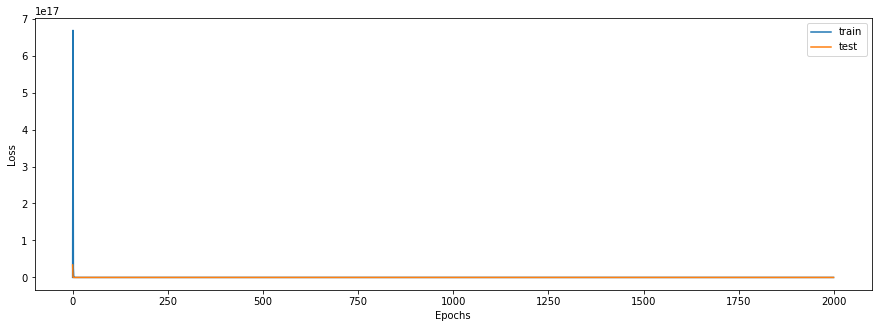

In [57]:
display_learning_curves(history)

In [58]:
original_mse = np.sqrt(baseline_model.evaluate(x=x_test, y=y_test, verbose=0))
# print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
# test_accuracy

In [59]:
original_mse

11334.95690331463

In [60]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
1995,151273280.0,162643952.0,1995
1996,151268400.0,162639104.0,1996
1997,151263536.0,162634256.0,1997
1998,151258704.0,162629360.0,1998
1999,151253824.0,162624512.0,1999


In [61]:
list(zip(baseline_model(x_test).numpy()[:,0], y_test))

[(485.82703, 5800.0),
 (485.82703, 5600.0),
 (485.82703, 800.0),
 (485.82703, 2300.0),
 (485.82703, 3400.0),
 (485.82703, 700.0),
 (485.82703, 700.0),
 (485.82703, 1900.0),
 (485.82703, 1200.0),
 (485.82703, 15700.0),
 (485.82703, 1600.0),
 (485.82703, 1600.0),
 (485.82703, 7000.0),
 (485.82703, 5400.0),
 (485.82703, 28200.0),
 (485.82703, 30000.0),
 (485.82703, 2500.0),
 (485.82703, 21600.0),
 (485.82703, 1400.0),
 (485.82703, 1600.0),
 (485.82703, 1900.0),
 (485.82703, 26800.0),
 (485.82703, 900.0),
 (485.82703, 5800.0),
 (485.82703, 10700.0),
 (485.82703, 700.0),
 (485.82703, 21500.0),
 (485.82703, 5100.0),
 (485.82703, 1100.0),
 (485.82703, 32700.0),
 (485.82703, 1700.0),
 (485.82703, 11000.0),
 (485.82703, 18600.0),
 (485.82703, 6000.0),
 (485.82703, 1500.0),
 (485.82703, 6300.0),
 (485.82703, 7200.0),
 (485.82703, 700.0),
 (485.82703, 3300.0),
 (485.82703, 3000.0),
 (485.82703, 600.0),
 (485.82703, 4000.0),
 (485.82703, 1800.0),
 (485.82703, 10200.0),
 (485.82703, 1000.0),
 (485.

### Modelo GNN - que considera os grafos

In [62]:
DROPOUT_RATE  =0.8

In [63]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=DROPOUT_RATE,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)


In [64]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=DROPOUT_RATE,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)


#### Preparação dos dados

In [65]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

In [66]:
graph_info = (node_features, edges, edge_weights)
print("Node features shape:", node_features.shape)
print("Edges shape:", edges.shape)
print("edge_weights shape:", edge_weights.shape)

Node features shape: (163, 17)
Edges shape: (2, 226)
edge_weights shape: (226,)


#### Instanciando o modelo

In [67]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=DROPOUT_RATE,
    name="gnn_model",
)


In [68]:
gnn_model([1,10])

<tf.Tensor: shape=(2, 17), dtype=float32, numpy=
array([[ 177743.94  ,  -19295.14  , -211225.56  ,   89181.47  ,
         258813.36  , -213695.53  ,   62762.484 ,  136800.31  ,
          99685.53  ,  182794.4   , -144471.    , -419355.97  ,
         -87861.83  ,  169048.06  , -269286.44  ,   36536.75  ,
         -63081.63  ],
       [  34316.25  ,   -3748.0605,  -40791.65  ,   17153.82  ,
          50603.773 ,  -41438.535 ,   12615.42  ,   25902.969 ,
          19041.473 ,   35335.16  ,  -28009.85  ,  -81372.81  ,
         -16981.854 ,   33073.523 ,  -52308.273 ,    7182.617 ,
         -12057.664 ]], dtype=float32)>

In [69]:
gnn_model.summary()

Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (163, 32)                 1828      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (163, 32)                 2368      
                                                                 
 logits (Dense)              multiple                  561       
                                                                 
Total params: 16,533
Trainable params: 15,667
Non-trainab

In [70]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/2000
1/1 [==============================] - 5s 5s/step - loss: 159548144.0000 - val_loss: 170842832.0000
Epoch 2/2000
1/1 [==============================] - 0s 31ms/step - loss: 159494848.0000 - val_loss: 170623968.0000
Epoch 3/2000
1/1 [==============================] - 0s 36ms/step - loss: 159417536.0000 - val_loss: 170522848.0000
Epoch 4/2000
1/1 [==============================] - 0s 41ms/step - loss: 159283856.0000 - val_loss: 170458768.0000
Epoch 5/2000
1/1 [==============================] - 0s 39ms/step - loss: 159008128.0000 - val_loss: 170384112.0000
Epoch 6/2000
1/1 [==============================] - 0s 33ms/step - loss: 158709520.0000 - val_loss: 170459184.0000
Epoch 7/2000
1/1 [==============================] - 0s 34ms/step - loss: 158029744.0000 - val_loss: 170439472.0000
Epoch 8/2000
1/1 [==============================] - 0s 35ms/step - loss: 157664816.0000 - val_loss: 170250992.0000
Epoch 9/2000
1/1 [==============================] - 0s 35ms/step - loss: 156920368

1/1 [==============================] - 0s 39ms/step - loss: 93018800.0000 - val_loss: 82088720.0000
Epoch 73/2000
1/1 [==============================] - 0s 34ms/step - loss: 92151936.0000 - val_loss: 82308568.0000
Epoch 74/2000
1/1 [==============================] - 0s 33ms/step - loss: 83809120.0000 - val_loss: 81800224.0000
Epoch 75/2000
1/1 [==============================] - 0s 33ms/step - loss: 97233744.0000 - val_loss: 81930264.0000
Epoch 76/2000
1/1 [==============================] - 0s 52ms/step - loss: 91220872.0000 - val_loss: 81996744.0000
Epoch 77/2000
1/1 [==============================] - 0s 41ms/step - loss: 87913920.0000 - val_loss: 81705896.0000
Epoch 78/2000
1/1 [==============================] - 0s 35ms/step - loss: 97869384.0000 - val_loss: 81833744.0000
Epoch 79/2000
1/1 [==============================] - 0s 36ms/step - loss: 103490648.0000 - val_loss: 81810888.0000
Epoch 80/2000
1/1 [==============================] - 0s 33ms/step - loss: 82400128.0000 - val_loss: 8

1/1 [==============================] - 0s 36ms/step - loss: 90013800.0000 - val_loss: 64677640.0000
Epoch 144/2000
1/1 [==============================] - 0s 33ms/step - loss: 84090280.0000 - val_loss: 65646700.0000
Epoch 145/2000
1/1 [==============================] - 0s 32ms/step - loss: 71069984.0000 - val_loss: 65744780.0000
Epoch 146/2000
1/1 [==============================] - 0s 32ms/step - loss: 81822720.0000 - val_loss: 65661224.0000
Epoch 147/2000
1/1 [==============================] - 0s 30ms/step - loss: 78267480.0000 - val_loss: 65399876.0000
Epoch 148/2000
1/1 [==============================] - 0s 37ms/step - loss: 93319544.0000 - val_loss: 65295000.0000
Epoch 149/2000
1/1 [==============================] - 0s 41ms/step - loss: 83211280.0000 - val_loss: 64709244.0000
Epoch 150/2000
1/1 [==============================] - 0s 33ms/step - loss: 82003048.0000 - val_loss: 63956740.0000
Epoch 151/2000
1/1 [==============================] - 0s 39ms/step - loss: 83348760.0000 - val_

1/1 [==============================] - 0s 32ms/step - loss: 83703920.0000 - val_loss: 68372216.0000
Epoch 215/2000
1/1 [==============================] - 0s 31ms/step - loss: 73611200.0000 - val_loss: 68430152.0000
Epoch 216/2000
1/1 [==============================] - 0s 29ms/step - loss: 82614160.0000 - val_loss: 67913392.0000
Epoch 217/2000
1/1 [==============================] - 0s 32ms/step - loss: 78203616.0000 - val_loss: 66354012.0000
Epoch 218/2000
1/1 [==============================] - 0s 31ms/step - loss: 63865152.0000 - val_loss: 63505956.0000
Epoch 219/2000
1/1 [==============================] - 0s 28ms/step - loss: 94043200.0000 - val_loss: 60932308.0000
Epoch 220/2000
1/1 [==============================] - 0s 28ms/step - loss: 69123216.0000 - val_loss: 58408248.0000
Epoch 221/2000
1/1 [==============================] - 0s 28ms/step - loss: 71768784.0000 - val_loss: 55903768.0000
Epoch 222/2000
1/1 [==============================] - 0s 31ms/step - loss: 98856008.0000 - val_

1/1 [==============================] - 0s 29ms/step - loss: 67539744.0000 - val_loss: 45042512.0000
Epoch 286/2000
1/1 [==============================] - 0s 57ms/step - loss: 79960360.0000 - val_loss: 46539940.0000
Epoch 287/2000
1/1 [==============================] - 0s 32ms/step - loss: 91694208.0000 - val_loss: 48431276.0000
Epoch 288/2000
1/1 [==============================] - 0s 29ms/step - loss: 67248440.0000 - val_loss: 48690612.0000
Epoch 289/2000
1/1 [==============================] - 0s 30ms/step - loss: 66404068.0000 - val_loss: 49475888.0000
Epoch 290/2000
1/1 [==============================] - 0s 29ms/step - loss: 76929936.0000 - val_loss: 49646764.0000
Epoch 291/2000
1/1 [==============================] - 0s 31ms/step - loss: 75526264.0000 - val_loss: 49421004.0000
Epoch 292/2000
1/1 [==============================] - 0s 33ms/step - loss: 67140320.0000 - val_loss: 48801532.0000
Epoch 293/2000
1/1 [==============================] - 0s 32ms/step - loss: 76975608.0000 - val_

1/1 [==============================] - 0s 32ms/step - loss: 63806484.0000 - val_loss: 53932132.0000
Epoch 357/2000
1/1 [==============================] - 0s 31ms/step - loss: 65239056.0000 - val_loss: 54557000.0000
Epoch 358/2000
1/1 [==============================] - 0s 31ms/step - loss: 59708340.0000 - val_loss: 54104164.0000
Epoch 359/2000
1/1 [==============================] - 0s 31ms/step - loss: 67148016.0000 - val_loss: 53096068.0000
Epoch 360/2000
1/1 [==============================] - 0s 32ms/step - loss: 86161152.0000 - val_loss: 52386024.0000
Epoch 361/2000
1/1 [==============================] - 0s 31ms/step - loss: 73171432.0000 - val_loss: 51248148.0000
Epoch 362/2000
1/1 [==============================] - 0s 44ms/step - loss: 88700408.0000 - val_loss: 50952100.0000
Epoch 363/2000
1/1 [==============================] - 0s 37ms/step - loss: 62539220.0000 - val_loss: 50738916.0000
Epoch 364/2000
1/1 [==============================] - 0s 31ms/step - loss: 72229648.0000 - val_

1/1 [==============================] - 0s 30ms/step - loss: 62454768.0000 - val_loss: 62481352.0000
Epoch 428/2000
1/1 [==============================] - 0s 32ms/step - loss: 65769172.0000 - val_loss: 62077464.0000
Epoch 429/2000
1/1 [==============================] - 0s 30ms/step - loss: 60924064.0000 - val_loss: 61851924.0000
Epoch 430/2000
1/1 [==============================] - 0s 29ms/step - loss: 80318120.0000 - val_loss: 61136436.0000
Epoch 431/2000
1/1 [==============================] - 0s 33ms/step - loss: 74864224.0000 - val_loss: 60290504.0000
Epoch 432/2000
1/1 [==============================] - 0s 29ms/step - loss: 72904928.0000 - val_loss: 59285768.0000
Epoch 433/2000
1/1 [==============================] - 0s 29ms/step - loss: 74155312.0000 - val_loss: 58011548.0000
Epoch 434/2000
1/1 [==============================] - 0s 35ms/step - loss: 86646640.0000 - val_loss: 56947420.0000
Epoch 435/2000
1/1 [==============================] - 0s 32ms/step - loss: 64962324.0000 - val_

1/1 [==============================] - 0s 30ms/step - loss: 63374948.0000 - val_loss: 53203468.0000
Epoch 499/2000
1/1 [==============================] - 0s 37ms/step - loss: 67592816.0000 - val_loss: 52374552.0000
Epoch 500/2000
1/1 [==============================] - 0s 36ms/step - loss: 64617328.0000 - val_loss: 51805428.0000
Epoch 501/2000
1/1 [==============================] - 0s 41ms/step - loss: 79244496.0000 - val_loss: 52134192.0000
Epoch 502/2000
1/1 [==============================] - 0s 48ms/step - loss: 60534284.0000 - val_loss: 53451108.0000
Epoch 503/2000
1/1 [==============================] - 0s 37ms/step - loss: 71654264.0000 - val_loss: 54937516.0000
Epoch 504/2000
1/1 [==============================] - 0s 35ms/step - loss: 73478080.0000 - val_loss: 56748952.0000
Epoch 505/2000
1/1 [==============================] - 0s 32ms/step - loss: 61802428.0000 - val_loss: 58155308.0000
Epoch 506/2000
1/1 [==============================] - 0s 34ms/step - loss: 66048496.0000 - val_

1/1 [==============================] - 0s 33ms/step - loss: 55751548.0000 - val_loss: 49519376.0000
Epoch 570/2000
1/1 [==============================] - 0s 32ms/step - loss: 73772856.0000 - val_loss: 49166128.0000
Epoch 571/2000
1/1 [==============================] - 0s 38ms/step - loss: 75111024.0000 - val_loss: 49365972.0000
Epoch 572/2000
1/1 [==============================] - 0s 52ms/step - loss: 52636916.0000 - val_loss: 49422956.0000
Epoch 573/2000
1/1 [==============================] - 0s 38ms/step - loss: 67206608.0000 - val_loss: 49739984.0000
Epoch 574/2000
1/1 [==============================] - 0s 32ms/step - loss: 65723268.0000 - val_loss: 50710504.0000
Epoch 575/2000
1/1 [==============================] - 0s 36ms/step - loss: 68954976.0000 - val_loss: 52597236.0000
Epoch 576/2000
1/1 [==============================] - 0s 34ms/step - loss: 49263832.0000 - val_loss: 55018980.0000
Epoch 577/2000
1/1 [==============================] - 0s 36ms/step - loss: 55315584.0000 - val_

1/1 [==============================] - 0s 33ms/step - loss: 78096600.0000 - val_loss: 50227092.0000
Epoch 641/2000
1/1 [==============================] - 0s 32ms/step - loss: 51352112.0000 - val_loss: 48905660.0000
Epoch 642/2000
1/1 [==============================] - 0s 30ms/step - loss: 52280564.0000 - val_loss: 47685304.0000
Epoch 643/2000
1/1 [==============================] - 0s 34ms/step - loss: 78928128.0000 - val_loss: 47194796.0000
Epoch 644/2000
1/1 [==============================] - 0s 32ms/step - loss: 62944544.0000 - val_loss: 47194660.0000
Epoch 645/2000
1/1 [==============================] - 0s 29ms/step - loss: 54607828.0000 - val_loss: 47577580.0000
Epoch 646/2000
1/1 [==============================] - 0s 29ms/step - loss: 53776868.0000 - val_loss: 47727528.0000
Epoch 647/2000
1/1 [==============================] - 0s 29ms/step - loss: 68465384.0000 - val_loss: 48905372.0000
Epoch 648/2000
1/1 [==============================] - 0s 29ms/step - loss: 62522676.0000 - val_

1/1 [==============================] - 0s 37ms/step - loss: 61007780.0000 - val_loss: 56439696.0000
Epoch 712/2000
1/1 [==============================] - 0s 45ms/step - loss: 59169240.0000 - val_loss: 57718568.0000
Epoch 713/2000
1/1 [==============================] - 0s 32ms/step - loss: 59569864.0000 - val_loss: 58516776.0000
Epoch 714/2000
1/1 [==============================] - 0s 36ms/step - loss: 80761648.0000 - val_loss: 59328400.0000
Epoch 715/2000
1/1 [==============================] - 0s 39ms/step - loss: 58383404.0000 - val_loss: 59186776.0000
Epoch 716/2000
1/1 [==============================] - 0s 34ms/step - loss: 73614768.0000 - val_loss: 58634884.0000
Epoch 717/2000
1/1 [==============================] - 0s 35ms/step - loss: 58813940.0000 - val_loss: 58517924.0000
Epoch 718/2000
1/1 [==============================] - 0s 36ms/step - loss: 64845700.0000 - val_loss: 58310136.0000
Epoch 719/2000
1/1 [==============================] - 0s 45ms/step - loss: 80805520.0000 - val_

1/1 [==============================] - 0s 41ms/step - loss: 80068976.0000 - val_loss: 61986168.0000
Epoch 783/2000
1/1 [==============================] - 0s 34ms/step - loss: 65332012.0000 - val_loss: 62036060.0000
Epoch 784/2000
1/1 [==============================] - 0s 33ms/step - loss: 55101160.0000 - val_loss: 61195180.0000
Epoch 785/2000
1/1 [==============================] - 0s 35ms/step - loss: 62289664.0000 - val_loss: 59882872.0000
Epoch 786/2000
1/1 [==============================] - 0s 39ms/step - loss: 56503000.0000 - val_loss: 58457296.0000
Epoch 787/2000
1/1 [==============================] - 0s 40ms/step - loss: 60657660.0000 - val_loss: 57525264.0000
Epoch 788/2000
1/1 [==============================] - 0s 46ms/step - loss: 59283852.0000 - val_loss: 56975316.0000
Epoch 789/2000
1/1 [==============================] - 0s 35ms/step - loss: 74319464.0000 - val_loss: 57003884.0000
Epoch 790/2000
1/1 [==============================] - 0s 28ms/step - loss: 42777944.0000 - val_

1/1 [==============================] - 0s 42ms/step - loss: 54153296.0000 - val_loss: 63127804.0000
Epoch 854/2000
1/1 [==============================] - 0s 35ms/step - loss: 49051472.0000 - val_loss: 62776112.0000
Epoch 855/2000
1/1 [==============================] - 0s 29ms/step - loss: 49055276.0000 - val_loss: 62435456.0000
Epoch 856/2000
1/1 [==============================] - 0s 30ms/step - loss: 75081552.0000 - val_loss: 62538844.0000
Epoch 857/2000
1/1 [==============================] - 0s 30ms/step - loss: 57862924.0000 - val_loss: 62623552.0000
Epoch 858/2000
1/1 [==============================] - 0s 30ms/step - loss: 42190936.0000 - val_loss: 61965700.0000
Epoch 859/2000
1/1 [==============================] - 0s 32ms/step - loss: 52820200.0000 - val_loss: 61496372.0000
Epoch 860/2000
1/1 [==============================] - 0s 37ms/step - loss: 67105172.0000 - val_loss: 61720056.0000
Epoch 861/2000
1/1 [==============================] - 0s 30ms/step - loss: 62765180.0000 - val_

1/1 [==============================] - 0s 30ms/step - loss: 66827984.0000 - val_loss: 55087556.0000
Epoch 925/2000
1/1 [==============================] - 0s 32ms/step - loss: 52868564.0000 - val_loss: 54081476.0000
Epoch 926/2000
1/1 [==============================] - 0s 33ms/step - loss: 68335416.0000 - val_loss: 54032980.0000
Epoch 927/2000
1/1 [==============================] - 0s 41ms/step - loss: 67872904.0000 - val_loss: 54270800.0000
Epoch 928/2000
1/1 [==============================] - 0s 34ms/step - loss: 55236344.0000 - val_loss: 54288240.0000
Epoch 929/2000
1/1 [==============================] - 0s 33ms/step - loss: 40612036.0000 - val_loss: 54358484.0000
Epoch 930/2000
1/1 [==============================] - 0s 35ms/step - loss: 58682268.0000 - val_loss: 54633320.0000
Epoch 931/2000
1/1 [==============================] - 0s 30ms/step - loss: 56439992.0000 - val_loss: 54977828.0000
Epoch 932/2000
1/1 [==============================] - 0s 30ms/step - loss: 47078000.0000 - val_

1/1 [==============================] - 0s 36ms/step - loss: 69785104.0000 - val_loss: 58915940.0000
Epoch 996/2000
1/1 [==============================] - 0s 31ms/step - loss: 64714996.0000 - val_loss: 59834136.0000
Epoch 997/2000
1/1 [==============================] - 0s 33ms/step - loss: 62879720.0000 - val_loss: 60552148.0000
Epoch 998/2000
1/1 [==============================] - 0s 35ms/step - loss: 63006948.0000 - val_loss: 61354056.0000
Epoch 999/2000
1/1 [==============================] - 0s 36ms/step - loss: 55828676.0000 - val_loss: 61860844.0000
Epoch 1000/2000
1/1 [==============================] - 0s 39ms/step - loss: 70265152.0000 - val_loss: 62076592.0000
Epoch 1001/2000
1/1 [==============================] - 0s 36ms/step - loss: 56652540.0000 - val_loss: 61635472.0000
Epoch 1002/2000
1/1 [==============================] - 0s 33ms/step - loss: 64354028.0000 - val_loss: 60916068.0000
Epoch 1003/2000
1/1 [==============================] - 0s 31ms/step - loss: 69923600.0000 - 

Epoch 1066/2000
1/1 [==============================] - 0s 33ms/step - loss: 74587672.0000 - val_loss: 57442180.0000
Epoch 1067/2000
1/1 [==============================] - 0s 38ms/step - loss: 73953504.0000 - val_loss: 57008844.0000
Epoch 1068/2000
1/1 [==============================] - 0s 39ms/step - loss: 70001320.0000 - val_loss: 56262360.0000
Epoch 1069/2000
1/1 [==============================] - 0s 32ms/step - loss: 66718392.0000 - val_loss: 56182380.0000
Epoch 1070/2000
1/1 [==============================] - 0s 32ms/step - loss: 70432008.0000 - val_loss: 56793564.0000
Epoch 1071/2000
1/1 [==============================] - 0s 34ms/step - loss: 44531628.0000 - val_loss: 57010492.0000
Epoch 1072/2000
1/1 [==============================] - 0s 32ms/step - loss: 69073440.0000 - val_loss: 57398008.0000
Epoch 1073/2000
1/1 [==============================] - 0s 34ms/step - loss: 59811800.0000 - val_loss: 57452332.0000
Epoch 1074/2000
1/1 [==============================] - 0s 35ms/step - lo

1/1 [==============================] - 0s 32ms/step - loss: 65628748.0000 - val_loss: 57205100.0000
Epoch 1137/2000
1/1 [==============================] - 0s 33ms/step - loss: 60728312.0000 - val_loss: 57088812.0000
Epoch 1138/2000
1/1 [==============================] - 0s 34ms/step - loss: 97626960.0000 - val_loss: 57949564.0000
Epoch 1139/2000
1/1 [==============================] - 0s 37ms/step - loss: 59290672.0000 - val_loss: 57905864.0000
Epoch 1140/2000
1/1 [==============================] - 0s 32ms/step - loss: 48990940.0000 - val_loss: 57940224.0000
Epoch 1141/2000
1/1 [==============================] - 0s 29ms/step - loss: 61314440.0000 - val_loss: 57714228.0000
Epoch 1142/2000
1/1 [==============================] - 0s 29ms/step - loss: 55498492.0000 - val_loss: 57798972.0000
Epoch 1143/2000
1/1 [==============================] - 0s 29ms/step - loss: 67933808.0000 - val_loss: 57785924.0000
Epoch 1144/2000
1/1 [==============================] - 0s 28ms/step - loss: 70413168.000

Epoch 1207/2000
1/1 [==============================] - 0s 37ms/step - loss: 48294084.0000 - val_loss: 47771316.0000
Epoch 1208/2000
1/1 [==============================] - 0s 31ms/step - loss: 74230544.0000 - val_loss: 49573172.0000
Epoch 1209/2000
1/1 [==============================] - 0s 32ms/step - loss: 61374136.0000 - val_loss: 50885644.0000
Epoch 1210/2000
1/1 [==============================] - 0s 30ms/step - loss: 60177400.0000 - val_loss: 51864636.0000
Epoch 1211/2000
1/1 [==============================] - 0s 30ms/step - loss: 72460880.0000 - val_loss: 52691300.0000
Epoch 1212/2000
1/1 [==============================] - 0s 33ms/step - loss: 62919816.0000 - val_loss: 53329652.0000
Epoch 1213/2000
1/1 [==============================] - 0s 31ms/step - loss: 52764204.0000 - val_loss: 53549336.0000
Epoch 1214/2000
1/1 [==============================] - 0s 37ms/step - loss: 66108280.0000 - val_loss: 53867444.0000
Epoch 1215/2000
1/1 [==============================] - 0s 32ms/step - lo

1/1 [==============================] - 0s 36ms/step - loss: 47309656.0000 - val_loss: 52710996.0000
Epoch 1278/2000
1/1 [==============================] - 0s 35ms/step - loss: 61685844.0000 - val_loss: 54079196.0000
Epoch 1279/2000
1/1 [==============================] - 0s 34ms/step - loss: 52086660.0000 - val_loss: 55409680.0000
Epoch 1280/2000
1/1 [==============================] - 0s 34ms/step - loss: 56202208.0000 - val_loss: 56599824.0000
Epoch 1281/2000
1/1 [==============================] - 0s 36ms/step - loss: 54134836.0000 - val_loss: 57801368.0000
Epoch 1282/2000
1/1 [==============================] - 0s 42ms/step - loss: 55815980.0000 - val_loss: 58525868.0000
Epoch 1283/2000
1/1 [==============================] - 0s 35ms/step - loss: 49670032.0000 - val_loss: 59360840.0000
Epoch 1284/2000
1/1 [==============================] - 0s 34ms/step - loss: 54527864.0000 - val_loss: 59519372.0000
Epoch 1285/2000
1/1 [==============================] - 0s 33ms/step - loss: 50357644.000

Epoch 1348/2000
1/1 [==============================] - 0s 32ms/step - loss: 72480392.0000 - val_loss: 56349112.0000
Epoch 1349/2000
1/1 [==============================] - 0s 32ms/step - loss: 59188360.0000 - val_loss: 55243828.0000
Epoch 1350/2000
1/1 [==============================] - 0s 34ms/step - loss: 68106952.0000 - val_loss: 54345052.0000
Epoch 1351/2000
1/1 [==============================] - 0s 29ms/step - loss: 73554392.0000 - val_loss: 54240188.0000
Epoch 1352/2000
1/1 [==============================] - 0s 36ms/step - loss: 79138064.0000 - val_loss: 55663016.0000
Epoch 1353/2000
1/1 [==============================] - 0s 35ms/step - loss: 46615648.0000 - val_loss: 57021136.0000
Epoch 1354/2000
1/1 [==============================] - 0s 34ms/step - loss: 39678440.0000 - val_loss: 58181576.0000
Epoch 1355/2000
1/1 [==============================] - 0s 32ms/step - loss: 76670216.0000 - val_loss: 60183508.0000
Epoch 1356/2000
1/1 [==============================] - 0s 29ms/step - lo

1/1 [==============================] - 0s 33ms/step - loss: 60307024.0000 - val_loss: 65500380.0000
Epoch 1419/2000
1/1 [==============================] - 0s 32ms/step - loss: 63702776.0000 - val_loss: 64318868.0000
Epoch 1420/2000
1/1 [==============================] - 0s 33ms/step - loss: 48795488.0000 - val_loss: 62550376.0000
Epoch 1421/2000
1/1 [==============================] - 0s 35ms/step - loss: 63586352.0000 - val_loss: 61176904.0000
Epoch 1422/2000
1/1 [==============================] - 0s 30ms/step - loss: 61092112.0000 - val_loss: 59129756.0000
Epoch 1423/2000
1/1 [==============================] - 0s 32ms/step - loss: 56179028.0000 - val_loss: 56522680.0000
Epoch 1424/2000
1/1 [==============================] - 0s 34ms/step - loss: 63483740.0000 - val_loss: 54601408.0000
Epoch 1425/2000
1/1 [==============================] - 0s 36ms/step - loss: 61736024.0000 - val_loss: 54202096.0000
Epoch 1426/2000
1/1 [==============================] - 0s 35ms/step - loss: 39786412.000

Epoch 1489/2000
1/1 [==============================] - 0s 33ms/step - loss: 63827936.0000 - val_loss: 55173924.0000
Epoch 1490/2000
1/1 [==============================] - 0s 34ms/step - loss: 57004216.0000 - val_loss: 54564844.0000
Epoch 1491/2000
1/1 [==============================] - 0s 31ms/step - loss: 51162000.0000 - val_loss: 53310448.0000
Epoch 1492/2000
1/1 [==============================] - 0s 30ms/step - loss: 54785800.0000 - val_loss: 52177264.0000
Epoch 1493/2000
1/1 [==============================] - 0s 33ms/step - loss: 57564544.0000 - val_loss: 51169944.0000
Epoch 1494/2000
1/1 [==============================] - 0s 40ms/step - loss: 75114728.0000 - val_loss: 51216536.0000
Epoch 1495/2000
1/1 [==============================] - 0s 31ms/step - loss: 64927180.0000 - val_loss: 51634096.0000
Epoch 1496/2000
1/1 [==============================] - 0s 31ms/step - loss: 60758744.0000 - val_loss: 51949284.0000
Epoch 1497/2000
1/1 [==============================] - 0s 32ms/step - lo

1/1 [==============================] - 0s 31ms/step - loss: 60364836.0000 - val_loss: 63648216.0000
Epoch 1560/2000
1/1 [==============================] - 0s 34ms/step - loss: 60147232.0000 - val_loss: 62098244.0000
Epoch 1561/2000
1/1 [==============================] - 0s 30ms/step - loss: 58700244.0000 - val_loss: 60497288.0000
Epoch 1562/2000
1/1 [==============================] - 0s 31ms/step - loss: 51976780.0000 - val_loss: 58868748.0000
Epoch 1563/2000
1/1 [==============================] - 0s 29ms/step - loss: 47093340.0000 - val_loss: 57055416.0000
Epoch 1564/2000
1/1 [==============================] - 0s 32ms/step - loss: 45552488.0000 - val_loss: 55411196.0000
Epoch 1565/2000
1/1 [==============================] - 0s 32ms/step - loss: 65262232.0000 - val_loss: 54080280.0000
Epoch 1566/2000
1/1 [==============================] - 0s 30ms/step - loss: 44773632.0000 - val_loss: 52397164.0000
Epoch 1567/2000
1/1 [==============================] - 0s 32ms/step - loss: 56741872.000

Epoch 1630/2000
1/1 [==============================] - 0s 36ms/step - loss: 61587060.0000 - val_loss: 62857948.0000
Epoch 1631/2000
1/1 [==============================] - 0s 32ms/step - loss: 54817256.0000 - val_loss: 64384016.0000
Epoch 1632/2000
1/1 [==============================] - 0s 36ms/step - loss: 67349096.0000 - val_loss: 65648768.0000
Epoch 1633/2000
1/1 [==============================] - 0s 38ms/step - loss: 50634056.0000 - val_loss: 65873924.0000
Epoch 1634/2000
1/1 [==============================] - 0s 48ms/step - loss: 58640232.0000 - val_loss: 65319780.0000
Epoch 1635/2000
1/1 [==============================] - 0s 40ms/step - loss: 57526384.0000 - val_loss: 64332920.0000
Epoch 1636/2000
1/1 [==============================] - 0s 35ms/step - loss: 66038240.0000 - val_loss: 63003512.0000
Epoch 1637/2000
1/1 [==============================] - 0s 35ms/step - loss: 63643784.0000 - val_loss: 61330172.0000
Epoch 1638/2000
1/1 [==============================] - 0s 32ms/step - lo

1/1 [==============================] - 0s 37ms/step - loss: 70888016.0000 - val_loss: 48526900.0000
Epoch 1701/2000
1/1 [==============================] - 0s 36ms/step - loss: 61132084.0000 - val_loss: 47621348.0000
Epoch 1702/2000
1/1 [==============================] - 0s 37ms/step - loss: 58011960.0000 - val_loss: 47284676.0000
Epoch 1703/2000
1/1 [==============================] - 0s 36ms/step - loss: 70062856.0000 - val_loss: 47547940.0000
Epoch 1704/2000
1/1 [==============================] - 0s 34ms/step - loss: 58827868.0000 - val_loss: 47704000.0000
Epoch 1705/2000
1/1 [==============================] - 0s 52ms/step - loss: 62516140.0000 - val_loss: 48996108.0000
Epoch 1706/2000
1/1 [==============================] - 0s 34ms/step - loss: 57733928.0000 - val_loss: 50642532.0000
Epoch 1707/2000
1/1 [==============================] - 0s 38ms/step - loss: 44206188.0000 - val_loss: 51697264.0000
Epoch 1708/2000
1/1 [==============================] - 0s 39ms/step - loss: 58500020.000

Epoch 1771/2000
1/1 [==============================] - 0s 45ms/step - loss: 64014180.0000 - val_loss: 51028712.0000
Epoch 1772/2000
1/1 [==============================] - 0s 38ms/step - loss: 43437224.0000 - val_loss: 51174072.0000
Epoch 1773/2000
1/1 [==============================] - 0s 36ms/step - loss: 46055476.0000 - val_loss: 51271952.0000
Epoch 1774/2000
1/1 [==============================] - 0s 38ms/step - loss: 58037540.0000 - val_loss: 51818576.0000
Epoch 1775/2000
1/1 [==============================] - 0s 39ms/step - loss: 53727992.0000 - val_loss: 52191792.0000
Epoch 1776/2000
1/1 [==============================] - 0s 41ms/step - loss: 59717976.0000 - val_loss: 52390824.0000
Epoch 1777/2000
1/1 [==============================] - 0s 71ms/step - loss: 47777476.0000 - val_loss: 52701164.0000
Epoch 1778/2000
1/1 [==============================] - 0s 38ms/step - loss: 49970988.0000 - val_loss: 53101300.0000
Epoch 1779/2000
1/1 [==============================] - 0s 33ms/step - lo

1/1 [==============================] - 0s 35ms/step - loss: 41024408.0000 - val_loss: 52004812.0000
Epoch 1842/2000
1/1 [==============================] - 0s 37ms/step - loss: 59007276.0000 - val_loss: 51866788.0000
Epoch 1843/2000
1/1 [==============================] - 0s 34ms/step - loss: 67905056.0000 - val_loss: 51650180.0000
Epoch 1844/2000
1/1 [==============================] - 0s 32ms/step - loss: 53641924.0000 - val_loss: 51338172.0000
Epoch 1845/2000
1/1 [==============================] - 0s 35ms/step - loss: 56082812.0000 - val_loss: 50820736.0000
Epoch 1846/2000
1/1 [==============================] - 0s 45ms/step - loss: 58210856.0000 - val_loss: 50392892.0000
Epoch 1847/2000
1/1 [==============================] - 0s 36ms/step - loss: 53361172.0000 - val_loss: 49618708.0000
Epoch 1848/2000
1/1 [==============================] - 0s 35ms/step - loss: 59907480.0000 - val_loss: 49026268.0000
Epoch 1849/2000
1/1 [==============================] - 0s 32ms/step - loss: 35725552.000

Epoch 1912/2000
1/1 [==============================] - 0s 52ms/step - loss: 55809572.0000 - val_loss: 49527276.0000
Epoch 1913/2000
1/1 [==============================] - 0s 36ms/step - loss: 67128632.0000 - val_loss: 49487592.0000
Epoch 1914/2000
1/1 [==============================] - 0s 32ms/step - loss: 51388948.0000 - val_loss: 49462980.0000
Epoch 1915/2000
1/1 [==============================] - 0s 30ms/step - loss: 46077564.0000 - val_loss: 49340680.0000
Epoch 1916/2000
1/1 [==============================] - 0s 30ms/step - loss: 66688544.0000 - val_loss: 49829212.0000
Epoch 1917/2000
1/1 [==============================] - 0s 32ms/step - loss: 57470988.0000 - val_loss: 50842488.0000
Epoch 1918/2000
1/1 [==============================] - 0s 35ms/step - loss: 50167624.0000 - val_loss: 51569604.0000
Epoch 1919/2000
1/1 [==============================] - 0s 40ms/step - loss: 60617896.0000 - val_loss: 52435712.0000
Epoch 1920/2000
1/1 [==============================] - 0s 34ms/step - lo

1/1 [==============================] - 0s 36ms/step - loss: 45784792.0000 - val_loss: 52773388.0000
Epoch 1983/2000
1/1 [==============================] - 0s 31ms/step - loss: 51443484.0000 - val_loss: 54398172.0000
Epoch 1984/2000
1/1 [==============================] - 0s 29ms/step - loss: 64710444.0000 - val_loss: 56095112.0000
Epoch 1985/2000
1/1 [==============================] - 0s 32ms/step - loss: 45302700.0000 - val_loss: 57054428.0000
Epoch 1986/2000
1/1 [==============================] - 0s 30ms/step - loss: 54971128.0000 - val_loss: 57356504.0000
Epoch 1987/2000
1/1 [==============================] - 0s 30ms/step - loss: 56927000.0000 - val_loss: 56937868.0000
Epoch 1988/2000
1/1 [==============================] - 0s 33ms/step - loss: 39622080.0000 - val_loss: 55985296.0000
Epoch 1989/2000
1/1 [==============================] - 0s 32ms/step - loss: 51361568.0000 - val_loss: 55142652.0000
Epoch 1990/2000
1/1 [==============================] - 0s 45ms/step - loss: 48900408.000

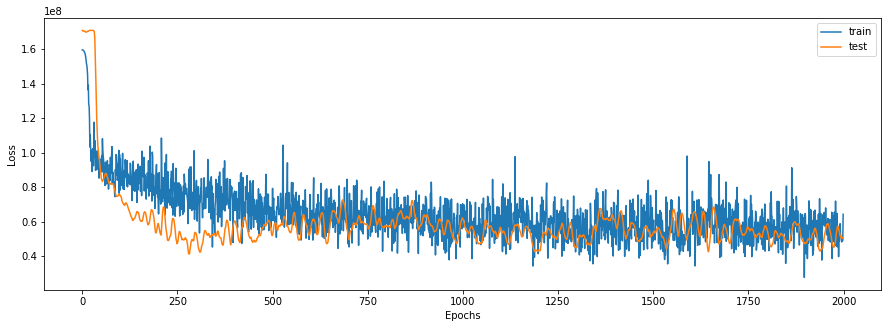

In [71]:
display_learning_curves(history)

In [72]:
x_test = test_data['Country ID'].to_numpy()

mse = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(np.sqrt(mse))

6549.323934575232


In [73]:
original_mse/np.sqrt(mse)

1.730706408256134

In [74]:
list(zip(gnn_model(x_test).numpy()[:,0], y_test))

[(4108.8633, 5800.0),
 (3810.3076, 5600.0),
 (3311.611, 800.0),
 (4325.345, 2300.0),
 (4184.5913, 3400.0),
 (3576.5256, 700.0),
 (2432.7078, 700.0),
 (3160.6099, 1900.0),
 (3139.1194, 1200.0),
 (11497.321, 15700.0),
 (3062.8633, 1600.0),
 (3993.112, 1600.0),
 (4925.7476, 7000.0),
 (4842.24, 5400.0),
 (12420.42, 28200.0),
 (12371.367, 30000.0),
 (4824.307, 2500.0),
 (11953.185, 21600.0),
 (4126.871, 1400.0),
 (3190.34, 1600.0),
 (3296.2893, 1900.0),
 (12833.519, 26800.0),
 (2708.2878, 900.0),
 (5044.6455, 5800.0),
 (4652.3804, 10700.0),
 (3280.1309, 700.0),
 (6528.0957, 21500.0),
 (4909.198, 5100.0),
 (3067.7139, 1100.0),
 (12673.653, 32700.0),
 (3045.9475, 1700.0),
 (5341.1553, 11000.0),
 (5895.595, 18600.0),
 (4806.0156, 6000.0),
 (4114.494, 1500.0),
 (5059.684, 6300.0),
 (4392.7715, 7200.0),
 (3736.999, 700.0),
 (4634.269, 3300.0),
 (3686.4727, 3000.0),
 (2951.7842, 600.0),
 (4160.8623, 4000.0),
 (3288.8325, 1800.0),
 (8263.588, 10200.0),
 (3649.2761, 1000.0),
 (5677.4966, 16900.0),
